In [40]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../../../mathematical_models"))
from mathematical_models.f_on_f import FunctionOnFunctionModel
from mathematical_models.s_on_f import ScalarOnFunctionModel
from datetime import datetime

sys.path.append(os.path.abspath("../../../optimizers"))
from optimizers.cordex_continuous import CordexContinuous
from optimizers.nbdo import NBDO

sys.path.append(os.path.abspath("../../basis"))
from basis.bspline import BSplineBasis
from basis.polynomial import PolynomialBasis
from basis.fourier import FourierBasis
from basis.basis import plot_design
from basis.basis import Basis

from J.jmatrix import JMatrix

#### Example 1

In [ ]:
x_base_1 = BSplineBasis(degree=3, total_knots_num=7)
b_base_1 = BSplineBasis(degree=1, total_knots_num=3)


x_base_2 = BSplineBasis(degree=3, total_knots_num=7)
b_base_2 = BSplineBasis(degree=2, total_knots_num=3)

bases_pairs = [(x_base_1, b_base_1),
               (x_base_2, b_base_2)]
x_bases = [x_base_1, x_base_2]
b_bases = [b_base_1, b_base_2]
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True)

In [ ]:
N = int(10*sum([len(b_base.internal_knots) + 2 + b_base.degree - 1 for b_base in b_bases]))
epochs = 100
refinement_epochs = 10

In [ ]:
N

In [ ]:
# optimizer = CordexDiscrete(model=model, runs=N, levels=[-1,1])
# optimizer = CordexContinuous(model=model, runs=N)
# best_design, best_objective_value = optimizer.optimize(epochs=epochs, refinement_epochs=refinement_epochs)

In [ ]:
optimizer = NBDO(model=model, latent_dim=4)
optimizer.compute_train_set(num_designs=500, runs=N, epsilon=1e-8)

In [ ]:
history = optimizer.fit(epochs=1000, patience=100)
best_objective_value, best_design = optimizer.optimize()
optimizer.clear_memory()

In [ ]:
print(f"Best objective value: {np.round(best_objective_value,3)} for {5, 5} bases.")
plot_design(best_design, x_bases, N,
            sub_x=10, sub_y=7, colour="#FFC100", figsize=(2*8, 2*6)) # FFC100

#### Example 2
zero bspline with [2,4,8,16,50] and 1st bspline 3split for b.

In [ ]:
num_of_bases = [2,4,8,16,50]
for num_of_basis in num_of_bases:
    x_base_1 = BSplineBasis(degree=0, num_basis_functions=num_of_basis)
    b_base_1 = BSplineBasis(degree=1, num_basis_functions=3)
    bases_pairs = [(x_base_1, b_base_1)]
    x_bases = [x_base_1]

    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf)
    optimizer = CordexContinuous(model=model, runs=N)
    best_design, best_objective_value = optimizer.optimize(epochs=epochs, refinement_epochs=refinement_epochs)
    plot_design(best_design, x_bases, N,
                sub_x=4, sub_y=3, colour="#000000") # FFC100
    print(f"Best objective value: {np.round(best_objective_value,3)} for {num_of_basis} bases.")

#### Example 3
zero bspline with [2,4,16] and 2nd bspline quadratic for b.

In [ ]:
num_of_bases = [2,3,4,8,16,100]
for num_of_basis in num_of_bases:
    x_base_1 = BSplineBasis(degree=0, num_basis_functions=num_of_basis)
    b_base_1 = BSplineBasis(degree=2, num_basis_functions=4)
    bases_pairs = [(x_base_1, b_base_1)]
    x_bases = [x_base_1]

    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf)
    optimizer = CordexContinuous(model=model, runs=N)
    best_design, best_objective_value = optimizer.optimize(epochs=epochs, refinement_epochs=refinement_epochs)
    plot_design(best_design, x_bases, N,
                sub_x=4, sub_y=3, colour="#000000") # FFC100
    print(f"Best objective value: {np.round(best_objective_value,3)} for {num_of_basis} bases.")

#### Example 4
zero bspline with [2,4,16] and 2nd bspline quadratic for b.

---

### Penalty

In [ ]:
x_base = BSplineBasis(degree=0, total_knots_num=4)
b_base = PolynomialBasis(degree=3)
bases_pairs = [(x_base, b_base)]
x_bases = [x_base]
b_bases = [b_base]
model_no_penalty = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True)
model_penalty = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=10, lambda_t=10)

In [ ]:
optimizer_no_penalty = CordexContinuous(model=model_no_penalty, runs=12)
optimizer_penalty = CordexContinuous(model=model_penalty, runs=12)

In [ ]:
best_design_no_penalty, best_objective_value_no_penalty = optimizer_no_penalty.optimize(epochs=100, refinement_epochs=1)
best_design_penalty, best_objective_value_penalty = optimizer_penalty.optimize(epochs=100, refinement_epochs=1)

In [ ]:
plot_design(best_design_no_penalty, x_bases, 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

In [ ]:
plot_design(best_design_penalty, x_bases, 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

In [ ]:
best_objective_value_no_penalty

---

In [51]:
from scipy.integrate import quad
from scipy.misc import derivative
from scipy.linalg import block_diag

def compute_DER_MAT(basis_pair, const=True):
    R_blocks = []

    for _, b_base in basis_pair:
        num_basis = b_base.num_basis()

        def second_derivative(i, t):
            return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)

        R = np.zeros((num_basis, num_basis))
        for i in range(num_basis):
            for j in range(num_basis):
                integrand = lambda t: second_derivative(i, t) * second_derivative(j, t)
                R[i, j], _ = quad(integrand, 0, 1)

        R_blocks.append(R)

    # Create block diagonal matrix from all R_blocks
    R_combined = block_diag(*R_blocks)
    if const:
        # Expand the final matrix to include the leading 1
        final_size = R_combined.shape[0] + 1
        R_with_one = np.zeros((final_size, final_size))
        R_with_one[0, 0] = 1
        R_with_one[1:, 1:] = R_combined

        return R_with_one
    else:
        return R_combined

In [54]:
L = 12
A = 50 * np.random.rand(L,L)
semi_def = A.T @ A
Sigma1 = semi_def + 5 * np.eye(L)

A = np.random.normal(12, 2, L*L).reshape(L,L)
semi_def = A.T @ A
Sigma2 = semi_def + 2 * np.eye(L)

In [52]:
L=3
bt_base = FourierBasis(num_basis_functions=12) # theta
j_thetatheta = [(bt_base, bt_base)]
S = compute_DER_MAT(j_thetatheta, const=False)
S

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the po

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.55854567e+03, -9.40472530e-04,
         5.92353684e-03,  4.22342924e-03,  1.10752343e-02,
        -8.66578268e-03,  1.07271593e-02, -9.72756262e-03,
        -3.69016282e-02, -4.18245805e-02,  3.38736559e-02],
       [ 0.00000000e+00, -9.40472530e-04,  1.55854334e+03,
         2.55684695e-03, -4.46219169e-03,  4.63180699e-03,
         1.10815448e-02, -1.65819740e-02, -1.87219090e-02,
        -7.94163925e-03,  2.91298495e-02,  2.30182605e-02],
       [ 0.00000000e+00,  5.92353684e-03,  2.55684695e-03,
         2.49367325e+04, -1.73740124e-02, -1.15869412e-03,
         2.82725321e-02, -3.48676489e-02, -7.85901217e-02,
         2.00046766e-02, -1.79905812e-01,  1.92533139e-01],
       [ 0.00000000e+00,  4.22342924e-03, -4.4621916

## Super Saturated

In [60]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=3, total_knots_num=15) # H # 6
bt_base = FourierBasis(num_basis_functions=12) # theta
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = np.round(JMatrix(jhh_pairs).compute(),3)
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = compute_DER_MAT(jhh_pairs, const=True)
S = np.round(compute_DER_MAT(j_thetatheta, const=False),3)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the po

In [61]:
np.round(R,3)

array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  3.2928001e+04, -4.5275998e+04,  9.6039990e+03,
         2.7440000e+03,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00, -4.5275998e+04,  6.5855999e+04, -1.8522000e+04,
        -2.7440000e+03,  6.8600000e+02,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.00

In [56]:
model_super_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_super_1.set_Sigma(Sigma1)
optimizer = CordexContinuous(model=model_super_1, runs=4)
best_design_super_1, best_objective_value_super_1 = optimizer.optimize(epochs=1000, refinement_epochs=10)

model_super_2 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_super_2.set_Sigma(Sigma2)
optimizer = CordexContinuous(model=model_super_2, runs=4)
best_design_super_2, best_objective_value_super_2 = optimizer.optimize(epochs=1000, refinement_epochs=10)

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [62]:
plot_design(best_design_super_1, [x_base], 4,
            sub_x=2, sub_y=2, colour="#FFC100") # FFC100

NameError: name 'best_design_super_1' is not defined

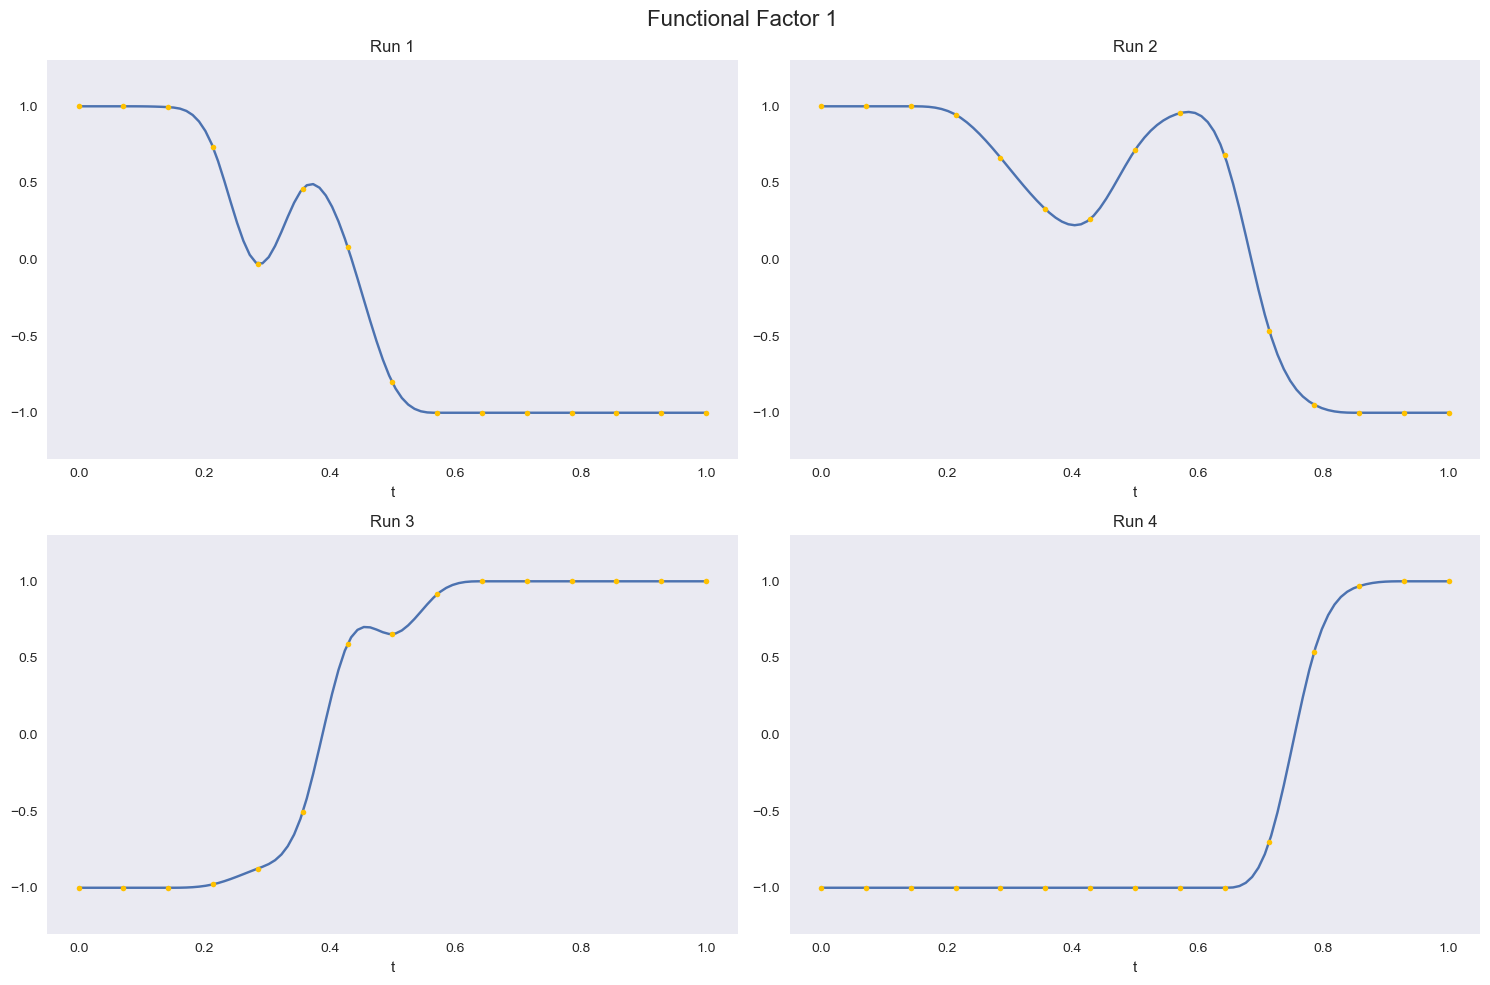

In [99]:
plot_design(best_design_super_2, [x_base], 4,
            sub_x=2, sub_y=2, colour="#FFC100") # FFC100

## Beta s 3

In [100]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=3) # H # 6
bt_base = FourierBasis(num_basis_functions=12) # theta
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = np.round(JMatrix(jhh_pairs).compute(),3)
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = np.round(compute_DER_MAT(jhh_pairs, const=True),3)
S = np.round(compute_DER_MAT(j_thetatheta, const=False),3)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folder

In [58]:
model_beta_3_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_beta_3_1.set_Sigma(Sigma1)
optimizer = CordexContinuous(model=model_beta_3_1, runs=12)
best_design_beta_3_1, best_objective_value_beta_3_1 = optimizer.optimize(epochs=1000, refinement_epochs=10)

model_beta_3_2 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_beta_3_2.set_Sigma(Sigma2)
optimizer = CordexContinuous(model=model_beta_3_2, runs=12)
best_design_beta_3_2, best_objective_value_beta_3_2 = optimizer.optimize(epochs=1000, refinement_epochs=10)

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


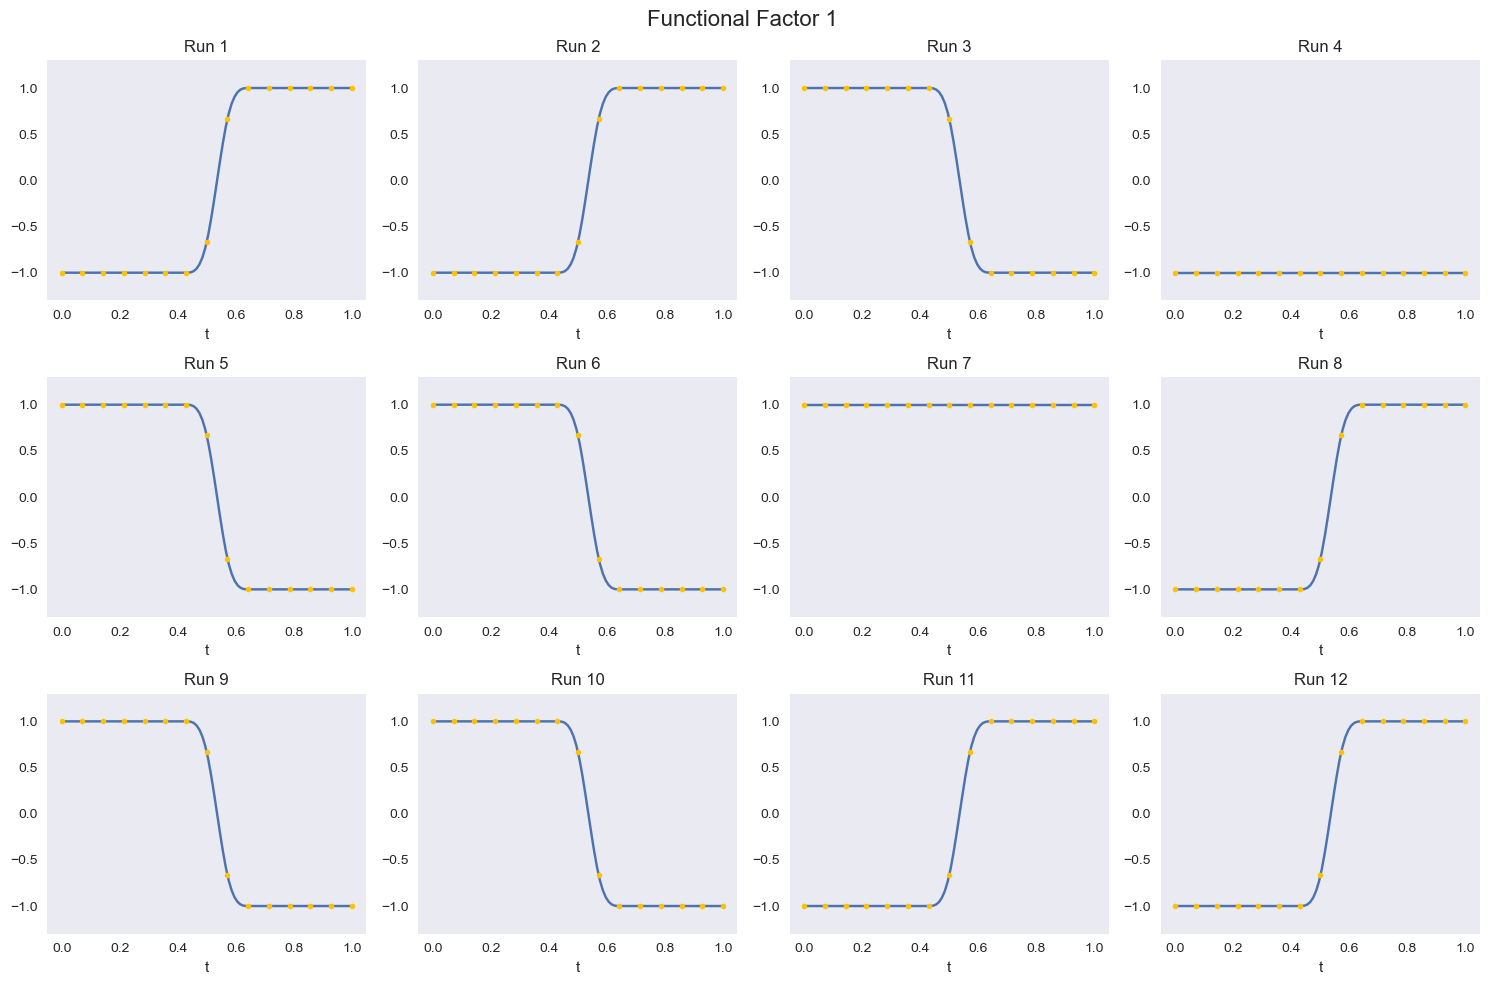

In [101]:
plot_design(best_design_beta_3_1, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

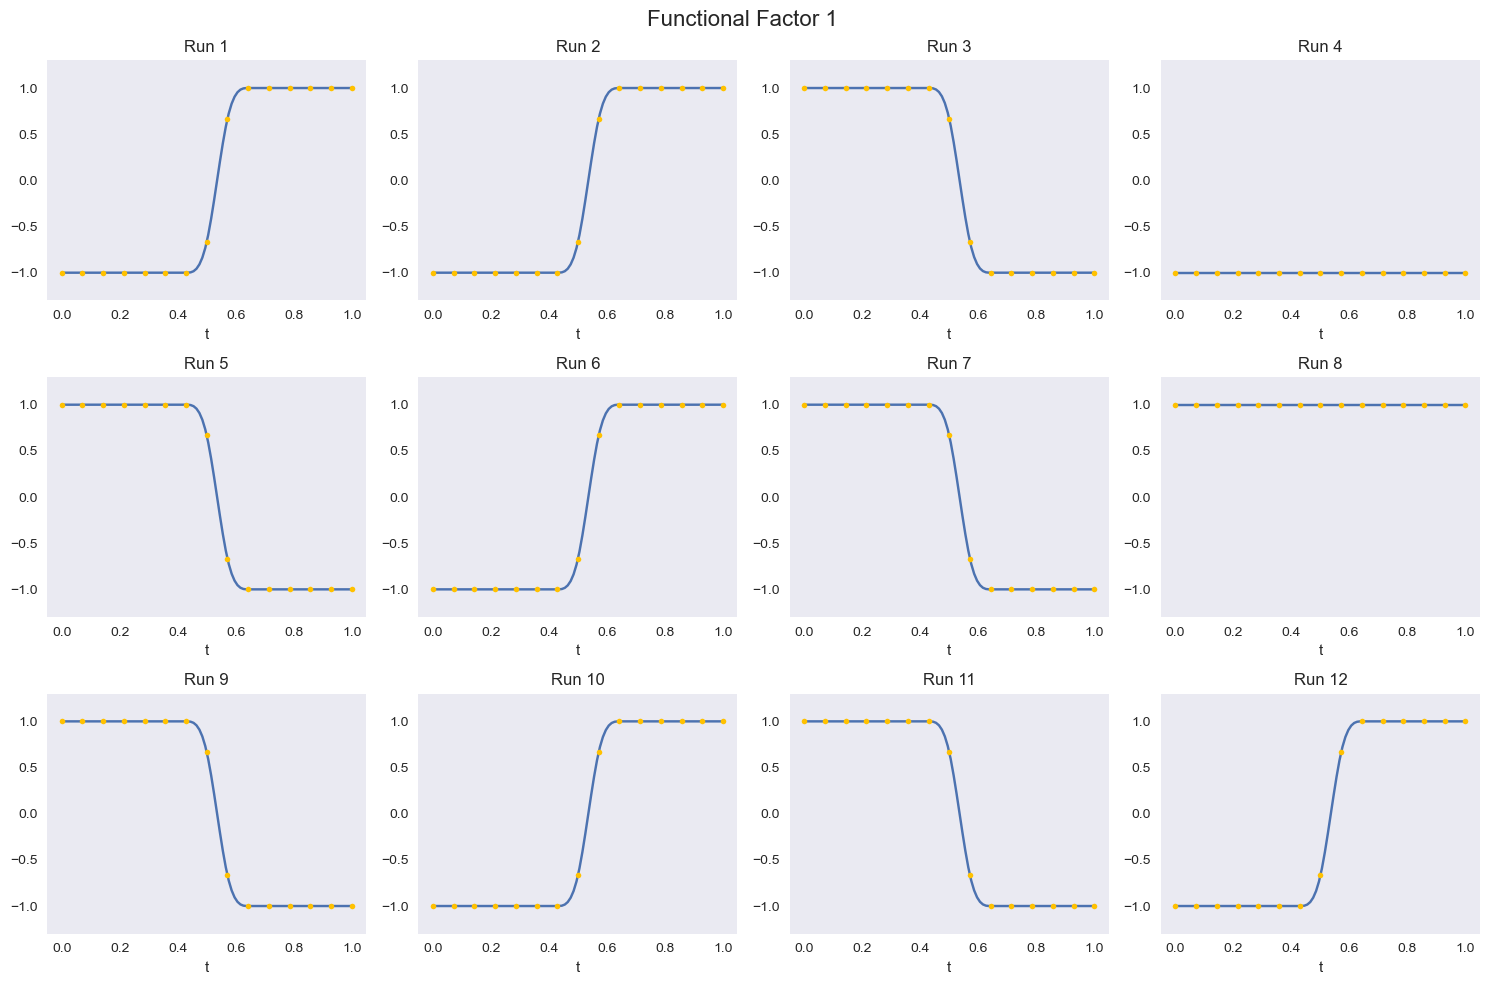

In [102]:
plot_design(best_design_beta_3_2, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

## Beta s 4

In [103]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=4) # H # 6
bt_base = FourierBasis(num_basis_functions=12) # theta
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = np.round(JMatrix(jhh_pairs).compute(),3)
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = np.round(compute_DER_MAT(jhh_pairs, const=True),3)
S = np.round(compute_DER_MAT(j_thetatheta, const=False),3)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folder

In [60]:
model_beta_4_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_beta_4_1.set_Sigma(Sigma1)
optimizer = CordexContinuous(model=model_beta_4_1, runs=12)
best_design_beta_4_1, best_objective_value_beta_4_1 = optimizer.optimize(epochs=1000, refinement_epochs=10)

model_beta_4_2 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_beta_4_2.set_Sigma(Sigma2)
optimizer = CordexContinuous(model=model_beta_4_2, runs=12)
best_design_beta_4_2, best_objective_value_beta_4_2 = optimizer.optimize(epochs=1000, refinement_epochs=10)

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


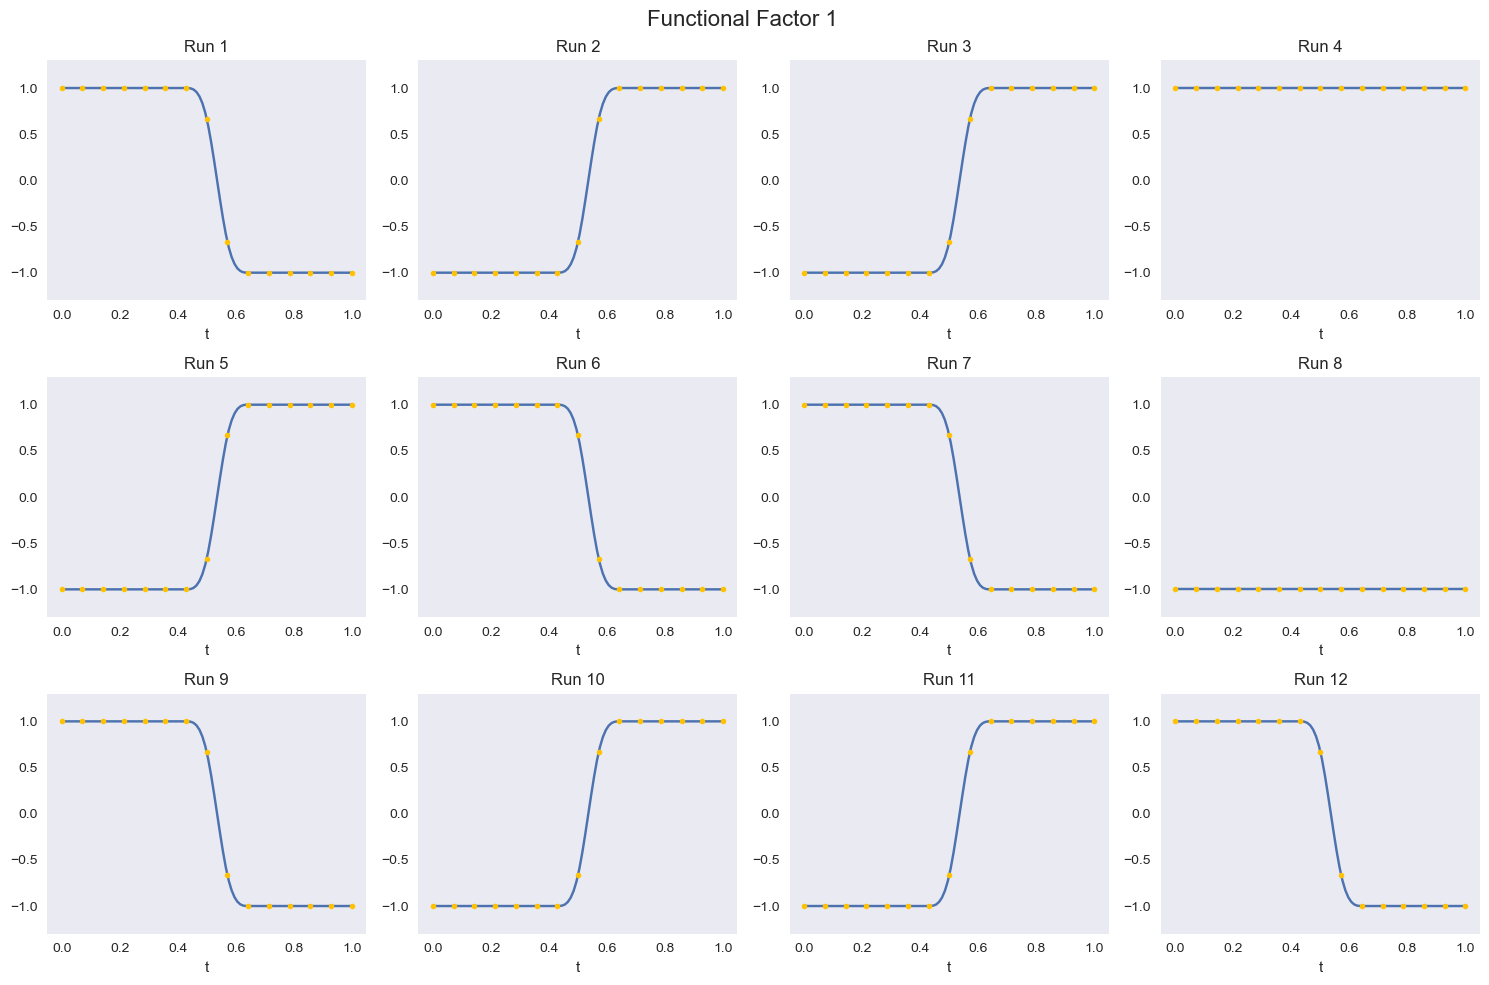

In [104]:
plot_design(best_design_beta_4_1, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

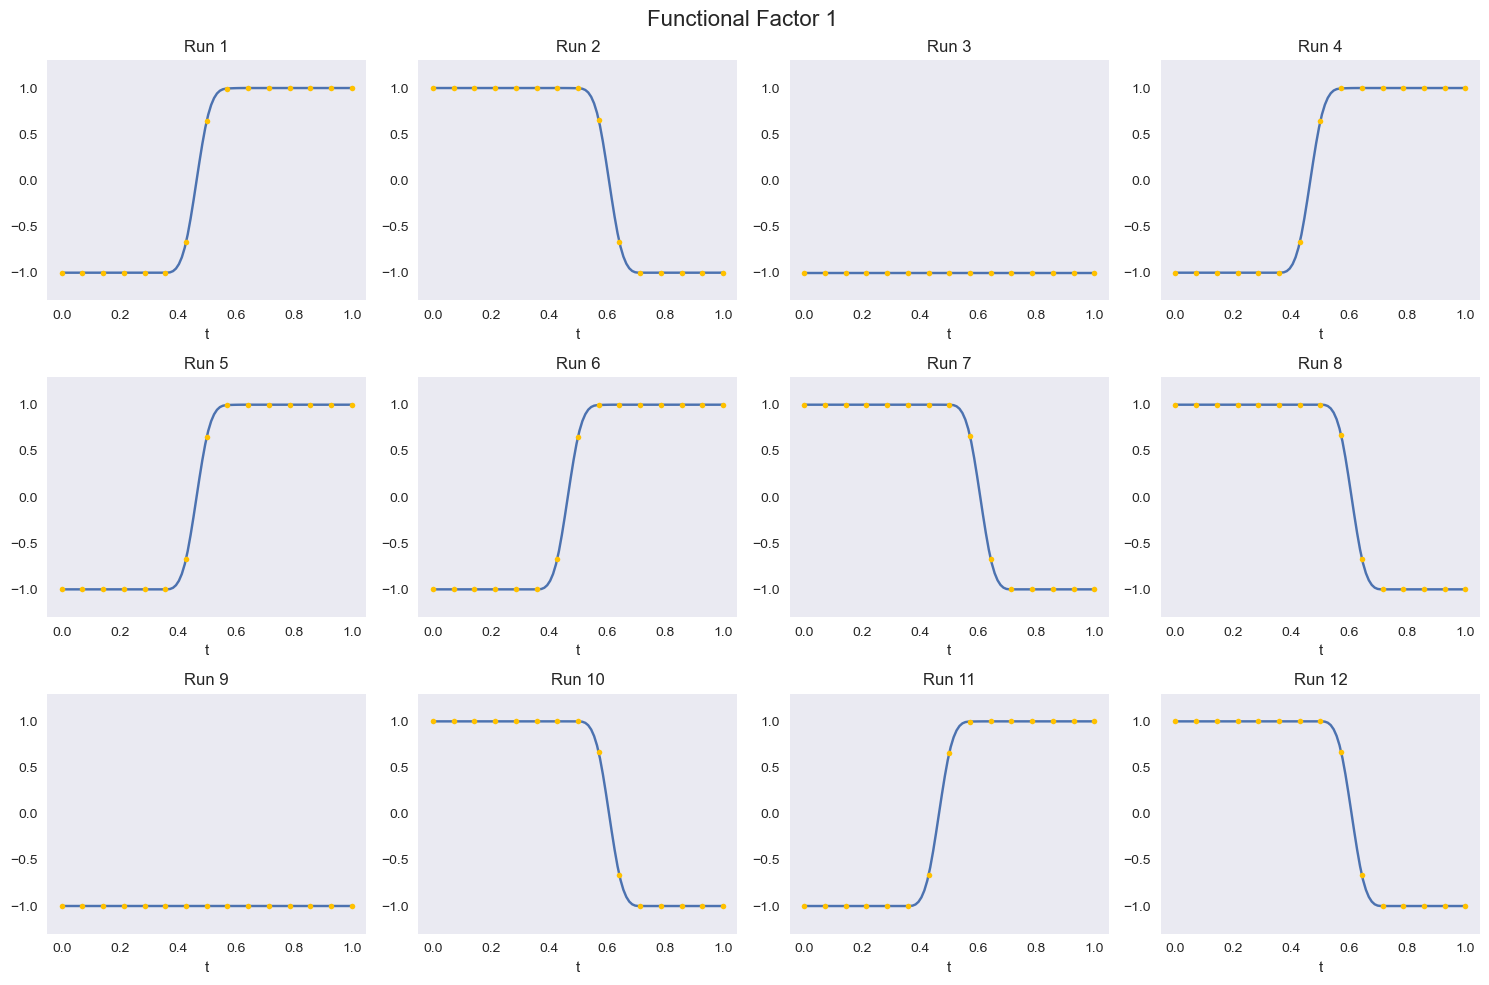

In [105]:
plot_design(best_design_beta_4_2, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

## Beta s 5

In [106]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=5) # H # 6
bt_base = FourierBasis(num_basis_functions=12) # theta
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = np.round(JMatrix(jhh_pairs).compute(),3)
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = np.round(compute_DER_MAT(jhh_pairs, const=True),3)
S = np.round(compute_DER_MAT(j_thetatheta, const=False),3)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folder

In [62]:
model_beta_5_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_beta_5_1.set_Sigma(Sigma1)
optimizer = CordexContinuous(model=model_beta_5_1, runs=12)
best_design_beta_5_1, best_objective_value_beta_5_1 = optimizer.optimize(epochs=1000, refinement_epochs=10)

model_beta_5_2 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_beta_5_2.set_Sigma(Sigma2)
optimizer = CordexContinuous(model=model_beta_5_2, runs=12)
best_design_beta_5_2, best_objective_value_beta_5_2 = optimizer.optimize(epochs=1000, refinement_epochs=10)

100%|██████████| 10/10 [00:47<00:00,  4.72s/it]


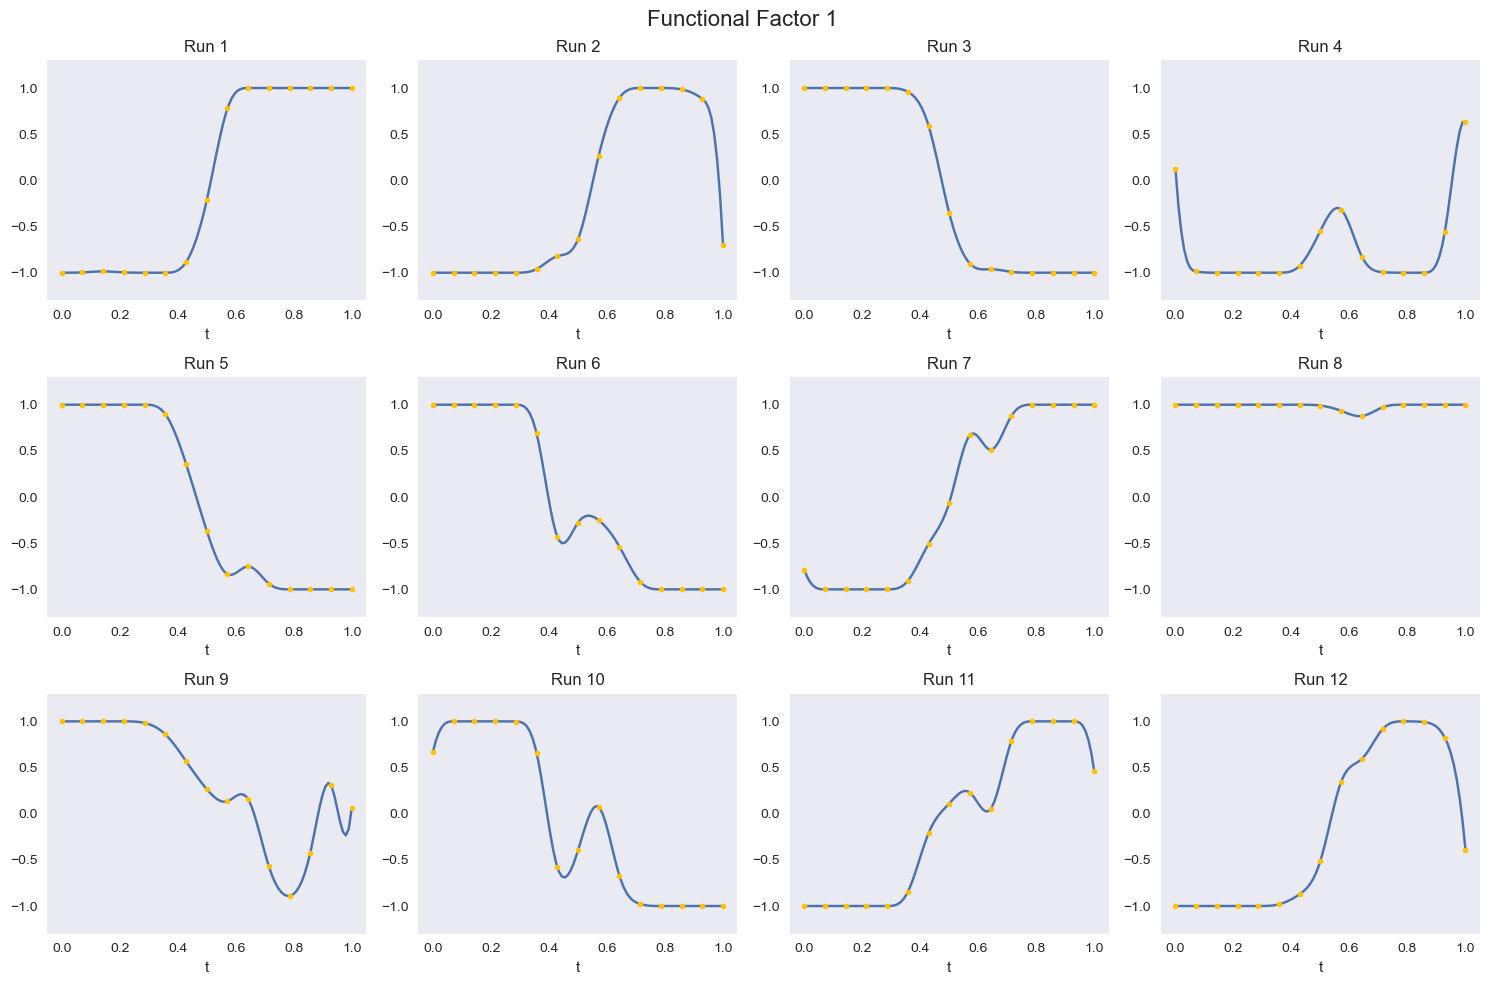

In [107]:
plot_design(best_design_beta_5_1, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

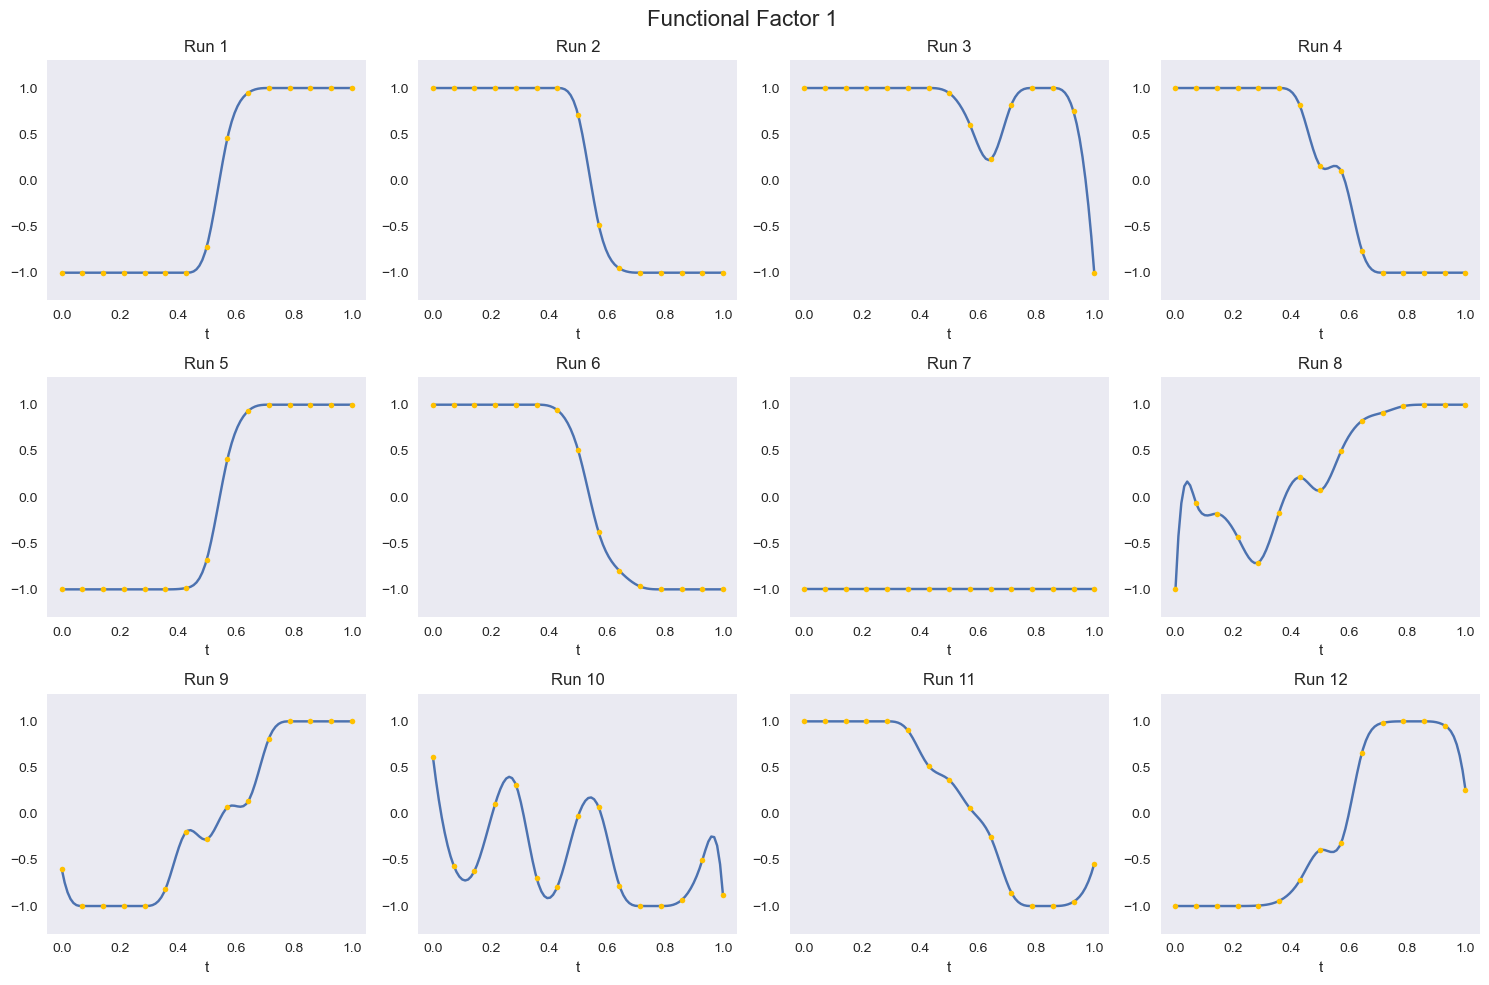

In [108]:
plot_design(best_design_beta_5_2, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100

---

---

In [22]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = PolynomialBasis(degree=4) # H # 6
bt_base = FourierBasis(num_basis_functions=12) # theta

bases_pairs = [(x_base, bs_base)]

In [23]:
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
# ---
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = np.round(JMatrix(jhh_pairs).compute(),3)
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = np.round(compute_DER_MAT(jhh_pairs, const=True),3)
S = np.round(compute_DER_MAT(j_thetatheta, const=False),3)

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folder

In [24]:
J_thetatheta

array([[ 1.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.],
       [ 0.,  1., -0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.],
       [ 0., -0.,  1.,  0., -0., -0., -0., -0., -0., -0.,  0., -0.],
       [-0.,  0.,  0.,  1., -0.,  0., -0., -0.,  0.,  0., -0., -0.],
       [ 0.,  0., -0., -0.,  1.,  0., -0., -0., -0., -0.,  0., -0.],
       [ 0.,  0., -0.,  0.,  0.,  1.,  0.,  0., -0., -0., -0.,  0.],
       [-0., -0., -0., -0., -0.,  0.,  1., -0., -0.,  0., -0., -0.],
       [-0., -0., -0., -0., -0.,  0., -0.,  1.,  0.,  0., -0., -0.],
       [-0., -0., -0.,  0., -0., -0., -0.,  0.,  1.,  0., -0., -0.],
       [ 0., -0., -0.,  0., -0., -0.,  0.,  0.,  0.,  1., -0., -0.],
       [-0.,  0.,  0., -0.,  0., -0., -0., -0., -0., -0.,  1.,  0.],
       [ 0.,  0., -0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  1.]])

In [35]:
R

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  6.],
       [ 0.,  0.,  0.,  6., 12.]])

In [26]:
J_CH

array([[0.018, 0.   , 0.   , 0.   ],
       [0.036, 0.002, 0.   , 0.   ],
       [0.054, 0.005, 0.   , 0.   ],
       [0.071, 0.01 , 0.002, 0.   ],
       [0.071, 0.015, 0.003, 0.001],
       [0.071, 0.02 , 0.006, 0.002],
       [0.071, 0.026, 0.009, 0.003],
       [0.071, 0.031, 0.013, 0.006],
       [0.071, 0.036, 0.018, 0.009],
       [0.071, 0.041, 0.023, 0.014],
       [0.071, 0.046, 0.03 , 0.019],
       [0.071, 0.051, 0.037, 0.026],
       [0.071, 0.056, 0.044, 0.035],
       [0.071, 0.061, 0.053, 0.045],
       [0.054, 0.049, 0.045, 0.041],
       [0.036, 0.034, 0.033, 0.031],
       [0.018, 0.018, 0.017, 0.017]])

In [27]:
J_HH

array([[1.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.5  , 0.333, 0.25 ],
       [0.   , 0.5  , 0.333, 0.25 , 0.2  ],
       [0.   , 0.333, 0.25 , 0.2  , 0.167],
       [0.   , 0.25 , 0.2  , 0.167, 0.143]])

---

### No Penalty

In [133]:
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True)

In [134]:
optimizer = CordexContinuous(model=model, runs=12)

In [137]:
best_design, best_objective_value = optimizer.optimize(epochs=1000, refinement_epochs=10)

100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


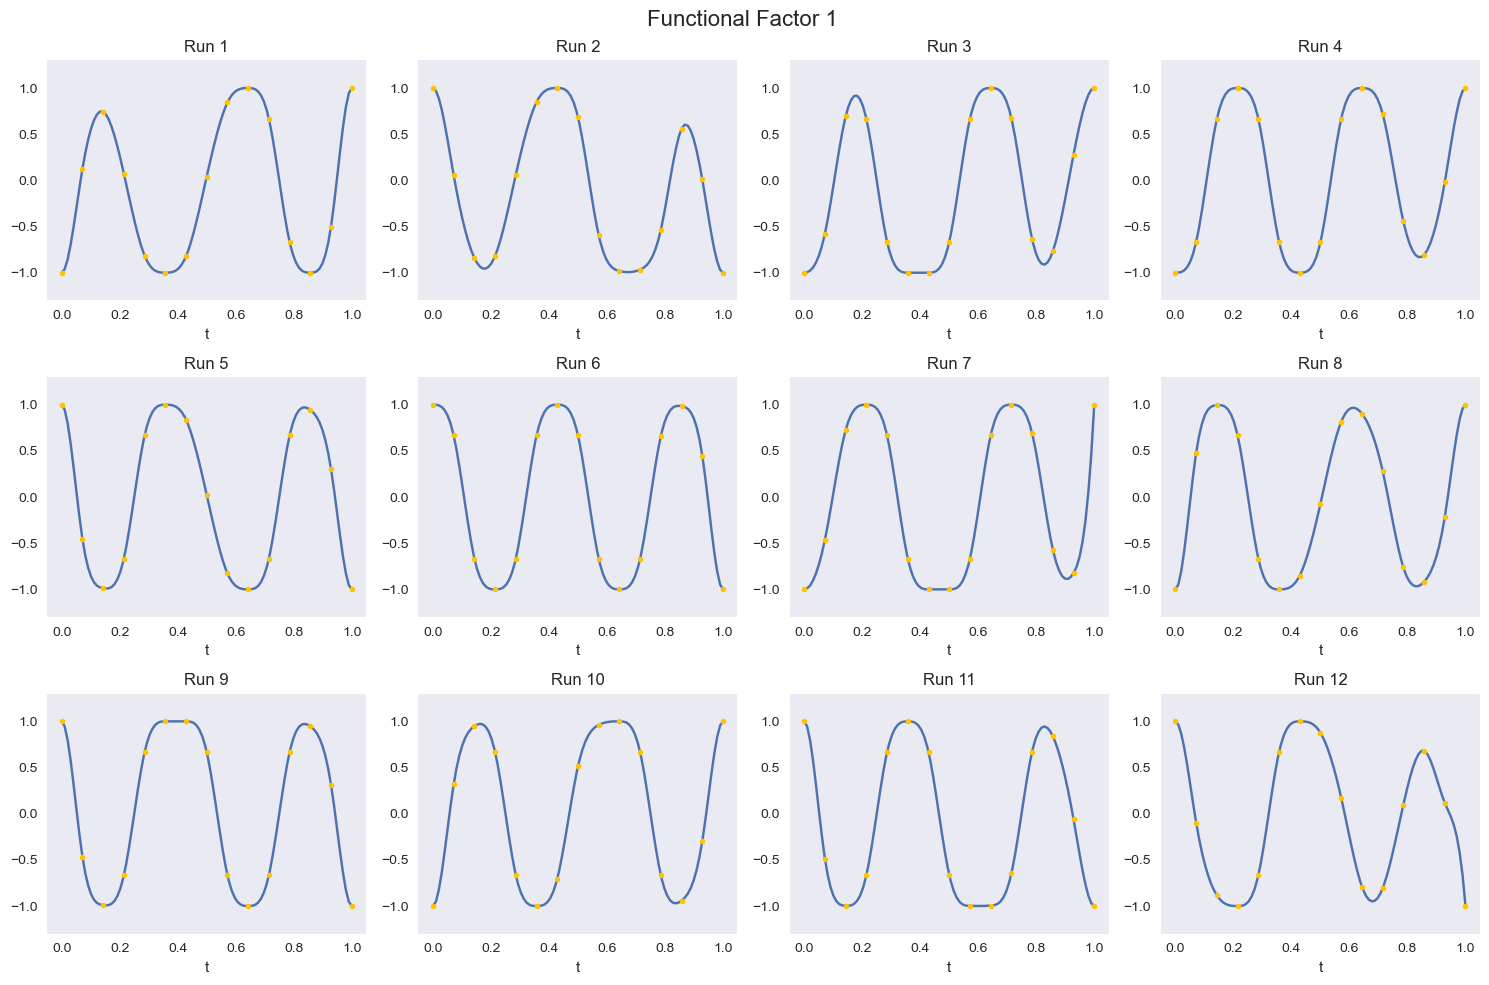

2318994.727889981


In [138]:
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100") # FFC100
print(best_objective_value)

---

### Caterina Example

In [28]:
L = 12
A = 50 * np.random.rand(L,L)
semi_def = A.T @ A
Sigma1 = semi_def + 5 * np.eye(L)

In [36]:
Sigma1

array([[ 7360.60865823,  7049.07688049,  7567.8166193 ,  6852.15722717,
         9188.01086472,  9010.89748945,  4983.9410986 ,  6463.9706959 ,
         5839.85008382,  5679.40170294,  7383.19415047,  6612.60295622],
       [ 7049.07688049, 10129.56873404,  8959.15174471,  6681.66271506,
        10441.02712653, 10009.7929179 ,  7363.76518781,  8694.36768154,
         6986.71615444,  7688.31130463,  9114.16798725,  7057.67580143],
       [ 7567.8166193 ,  8959.15174471, 10715.88728827,  8445.65034796,
         9676.68559045,  8960.52464526,  7159.53914632,  7968.17173878,
         7416.91232851,  7983.01739943, 10385.24182089,  7375.70871741],
       [ 6852.15722717,  6681.66271506,  8445.65034796,  9097.35390498,
         8254.04218191,  7071.95416887,  5877.38415895,  7356.72618638,
         6657.13677128,  6767.14625223,  8722.47192049,  6882.45457886],
       [ 9188.01086472, 10441.02712653,  9676.68559045,  8254.04218191,
        13317.01166858, 12603.89158611,  7571.02202946,  981

In [29]:
A2 = np.random.normal(12, 2, L*L).reshape(L,L)
semi_def = A2.T @ A2
Sigma2 = semi_def + 2 * np.eye(L)

In [37]:
Sigma2

array([[1818.61084731, 1522.58543223, 1758.97225311, 1585.26932825,
        1842.22378158, 1565.94568382, 1738.45125374, 1735.18326341,
        1771.32242705, 1829.08508916, 1846.68716182, 1725.4188467 ],
       [1522.58543223, 1346.84704673, 1533.30652812, 1377.87986932,
        1561.49339336, 1331.08119018, 1468.04957034, 1518.6570016 ,
        1510.19727055, 1554.39701797, 1582.82942581, 1490.74739886],
       [1758.97225311, 1533.30652812, 1879.85303838, 1602.18036861,
        1832.34644161, 1573.01479615, 1719.15738194, 1824.13802054,
        1772.34916985, 1827.90328973, 1841.5440297 , 1772.19437914],
       [1585.26932825, 1377.87986932, 1602.18036861, 1463.99743831,
        1624.89788065, 1419.36203822, 1527.21493169, 1596.87984166,
        1613.95737253, 1616.95703616, 1650.23342314, 1560.81112577],
       [1842.22378158, 1561.49339336, 1832.34644161, 1624.89788065,
        1919.3376057 , 1599.24866969, 1774.62812079, 1796.5939953 ,
        1819.86456847, 1885.60562563, 1869.2

In [30]:
lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

In [ ]:
model_caterina_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())

### Kalliopis Number Example

In [183]:
L = 3
A = 50 * np.random.rand(L,L)
semi_def = A.T @ A
Sigma_kalliopi = semi_def + 5 * np.eye(L)

x_base = BSplineBasis(degree=1, total_knots_num=6) # C
bs_base = PolynomialBasis(degree=7) # H
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = np.round(compute_DER_MAT(jhh_pairs, const=True),3)
S = np.round(compute_DER_MAT(j_thetatheta, const=False),3)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_23140/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the po

In [184]:
J_HH

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.85714286e-02, 1.75000000e-02, 3.69047619e-03,
        2.38095238e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 1.75000000e-02, 4.42857143e-02, 3.12500000e-02,
        6.90476190e-03, 5.95238095e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 3.69047619e-03, 3.12500000e-02, 6.53571429e-02,
        4.49206349e-02, 4.74206349e-03, 3.96825397e-05, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.38095238e-04, 6.90476190e-03, 4.49206349e-02,
        9.58730159e-02, 4.72619048e-02, 4.74206349e-03, 5.95238095e-05,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.95238095e-05, 4.74206349e-03,
        4.72619048e-02, 9.58730159e-02, 4.49206349e-02, 6.90476190e-03,
        2.3

In [72]:
model_kalliopi = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_kalliopi.set_Sigma(Sigma_kalliopi)
optimizer = CordexContinuous(model=model_kalliopi, runs=12)
best_design_kalliopi, best_objective_value_kallipi = optimizer.optimize(epochs=1000, refinement_epochs=10)

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


In [115]:
# Suppose R is an n x m matrix
n, m = R.shape

# Create a new (n+1) x (m+1) matrix of zeros
R_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
R_aug[0, 0] = 1

# Place the original R into the bottom-right block
R_aug[1:, 1:] = R

In [126]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH

In [161]:
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X

array([[12.        , 12.        , 12.        , -7.15170375, -8.        ,
        -8.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        ],
       [12.        , 12.        , 12.        , -7.15170375, -8.        ,
        -8.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        ],
       [12.        , 12.        , 12.        , -7.15170375, -8.        ,
        -8.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        ],
       [-7.15170375, -7.15170375, -7.15170375, 10.37541723, 11.15170375,
        11.15170375, -0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.        , -0.        , -0.   

In [162]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X
F_lambda_S = lambda_s * np.kron(np.eye(bt_base.num_basis()), R_aug)
F_lambda_S

array([[0.02083333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.02083333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
    

In [163]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X
F_lambda_S = lambda_s * np.kron(np.eye(bt_base.num_basis()), R_aug)
F_lambda_S
F_lambda_T = lambda_t * np.kron(S, J_HH_aug)
F_lambda_T

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e

In [164]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X
F_lambda_S = lambda_s * np.kron(np.eye(bt_base.num_basis()), R_aug)
F_lambda_S
F_lambda_T = lambda_t * np.kron(S, J_HH_aug)
F_lambda_T
F_lambda = F_lambda_X + F_lambda_S + F_lambda_T
F_lambda

array([[ 1.20208333e+01,  1.20000000e+01,  1.20000000e+01,
        -7.15170375e+00, -8.00000000e+00, -8.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.20000000e+01,  1.20208333e+01,  1.20000000e+01,
        -7.15170375e+00, -8.00000000e+00, -8.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.20000000e+01,  1.20000000e+01,  1.20000000e+01,
        -7.15170375e+00, -8.00000000e+00, -8.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e

In [166]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X
F_lambda_S = lambda_s * np.kron(np.eye(bt_base.num_basis()), R_aug)
F_lambda_S
F_lambda_T = lambda_t * np.kron(S, J_HH_aug)
F_lambda_T
F_lambda = F_lambda_X + F_lambda_S + F_lambda_T
F_lambda
F_lambda_inv = np.round(np.linalg.inv(F_lambda),3)
F_lambda_inv

array([[ 4.8000e+01,  0.0000e+00, -4.8000e+01,  0.0000e+00, -0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  4.8000e+01, -4.8000e+01,  0.0000e+00, -0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-4.8000e+01, -4.8000e+01,  9.6173e+01, -6.4200e-01,  1.0620e+00,
        -3.5400e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00],
       [-0.0000e+00,  0.0000e+00, -6.4200e-01,  1.7597e+01, -2.5041e+01,
         8.3470e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.000

In [133]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X
F_lambda_S = lambda_s * np.kron(np.eye(bt_base.num_basis()), R_aug)
F_lambda_S
F_lambda_T = lambda_t * np.kron(S, J_HH_aug)
F_lambda_T
F_lambda = F_lambda_X + F_lambda_S + F_lambda_T
F_lambda
F_lambda_inv = np.round(np.linalg.inv(F_lambda),3)
F_lambda_inv
Sigma_cross_ZTZ = np.kron(Sigma_kalliopi, Z.T @ Z)
Sigma_cross_ZTZ

array([[ 32173.23660535,  32173.23660535,  32173.23660535,
        -19174.45474482, -21448.82440357, -21448.82440357,
         18934.5242481 ,  18934.5242481 ,  18934.5242481 ,
        -11284.50900863, -12623.0161654 , -12623.0161654 ,
         23335.70357487,  23335.70357487,  23335.70357487,
        -13907.50323393, -15557.13571658, -15557.13571658],
       [ 32173.23660535,  32173.23660535,  32173.23660535,
        -19174.45474482, -21448.82440357, -21448.82440357,
         18934.5242481 ,  18934.5242481 ,  18934.5242481 ,
        -11284.50900863, -12623.0161654 , -12623.0161654 ,
         23335.70357487,  23335.70357487,  23335.70357487,
        -13907.50323393, -15557.13571658, -15557.13571658],
       [ 32173.23660535,  32173.23660535,  32173.23660535,
        -19174.45474482, -21448.82440357, -21448.82440357,
         18934.5242481 ,  18934.5242481 ,  18934.5242481 ,
        -11284.50900863, -12623.0161654 , -12623.0161654 ,
         23335.70357487,  23335.70357487,  23335.70357

In [137]:

left_F_inv = F_lambda_inv @ Sigma_cross_ZTZ
left_F_inv

array([[ 1.56291671e-09,  1.56291671e-09,  1.56291671e-09,
        -6.63421806e-10, -7.65329448e-10, -7.65329448e-10,
         9.95374526e-10,  9.95374526e-10,  9.95374526e-10,
        -4.27115735e-10, -4.40865001e-10, -4.40865001e-10,
         1.11395587e-09,  1.11395587e-09,  1.11395587e-09,
        -4.87039350e-10, -5.27931510e-10, -5.27931510e-10],
       [ 3.11202238e-10,  3.11202238e-10,  3.11202238e-10,
         4.40606316e-10,  4.81728720e-10,  4.81728720e-10,
         2.83107270e-10,  2.83107270e-10,  2.83107270e-10,
         2.54445378e-10,  2.37986516e-10,  2.37986516e-10,
         1.83919403e-10,  1.83919403e-10,  1.83919403e-10,
         2.72760550e-10,  3.52539148e-10,  3.52539148e-10],
       [ 3.31697778e+03,  3.31697778e+03,  3.31697778e+03,
         2.65969361e+02,  1.30154710e+02,  1.30154710e+02,
         1.95210066e+03,  1.95210066e+03,  1.95210066e+03,
         1.56527718e+02,  7.65983708e+01,  7.65983708e+01,
         2.40585090e+03,  2.40585090e+03,  2.40585090e

In [136]:
Final = left_F_inv @ F_lambda_inv
Final


array([[ 2.41510693e-24,  5.78328330e-24,  2.12864738e-10,
        -1.62137465e-09,  2.37475455e-09, -7.91584849e-10,
         3.68284773e-11,  3.68284773e-11,  2.27330816e-11,
         1.46835329e-10, -3.42660301e-10,  2.31688364e-10,
         4.01802220e-11,  4.01802220e-11,  2.79078374e-11,
         8.64856914e-11, -1.84137893e-10,  1.30567851e-10],
       [ 1.67804932e-23,  5.29993482e-25, -4.40538855e-11,
         4.06002109e-09, -5.63850014e-09,  1.87950005e-09,
         3.13075340e-11,  3.13075340e-11,  3.62227658e-12,
        -2.93890877e-11,  1.72189913e-10, -8.09079079e-11,
         2.82429218e-11,  2.82429218e-11, -7.20014626e-12,
         2.50518352e-10, -5.61244433e-10,  3.87496159e-10],
       [-1.32692522e-11,  9.05200061e-12,  6.51874836e+02,
        -4.21331303e+03,  6.53275763e+03, -2.17758588e+03,
         1.26911160e+02,  1.26911160e+02,  3.89015389e+01,
         3.88258413e+01,  1.98858830e+02, -3.52256035e+01,
         1.56410648e+02,  1.56410648e+02,  4.79438917e

### Penalty Small

In [148]:
model_penalty = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=0, lambda_t=0, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())

In [149]:
optimizer_penalty = CordexContinuous(model=model_penalty, runs=6)

In [150]:
best_design_penalty, best_objective_value_penalty = optimizer_penalty.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:00<00:00, 129.19it/s]


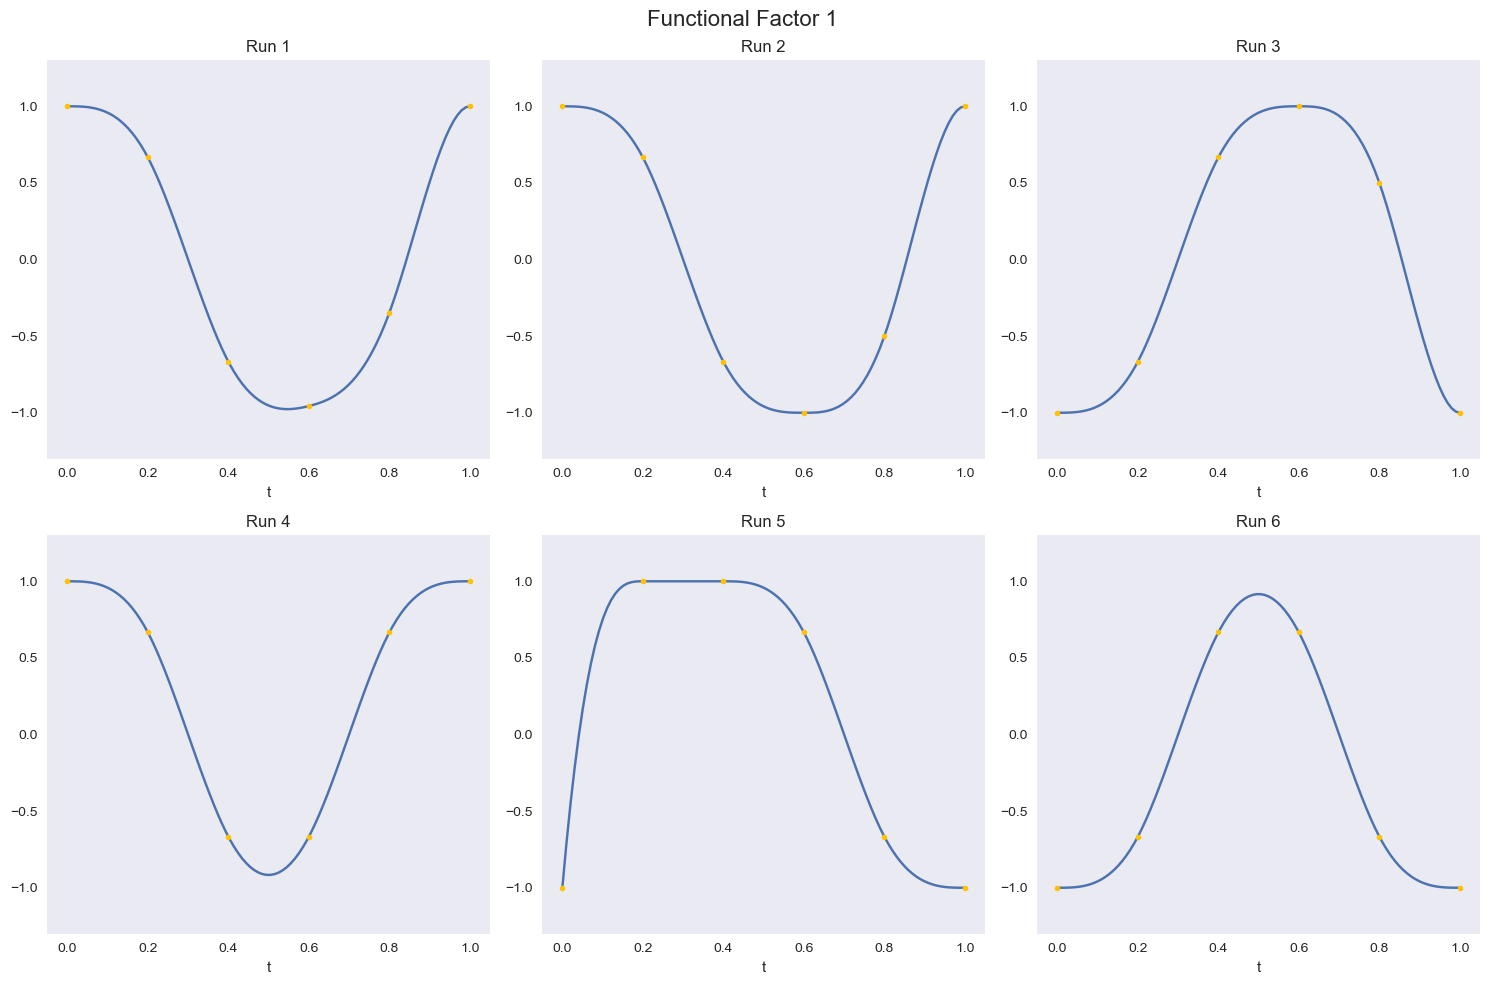

181.21496386327414


In [151]:
plot_design(best_design_penalty, [x_base], 6,
            sub_x=2, sub_y=3, colour="#FFC100") # FFC100
print(best_objective_value_penalty)

---

### Penalty Large

In [109]:
model_penalty_large = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=10, lambda_t=10, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())

In [132]:
model_penalty_large.Sigma

array([[1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [110]:
optimizer_penalty_large = CordexContinuous(model=model_penalty_large, runs=6)

In [111]:
best_design_penalty_large, best_objective_value_penalty_large = optimizer_penalty_large.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


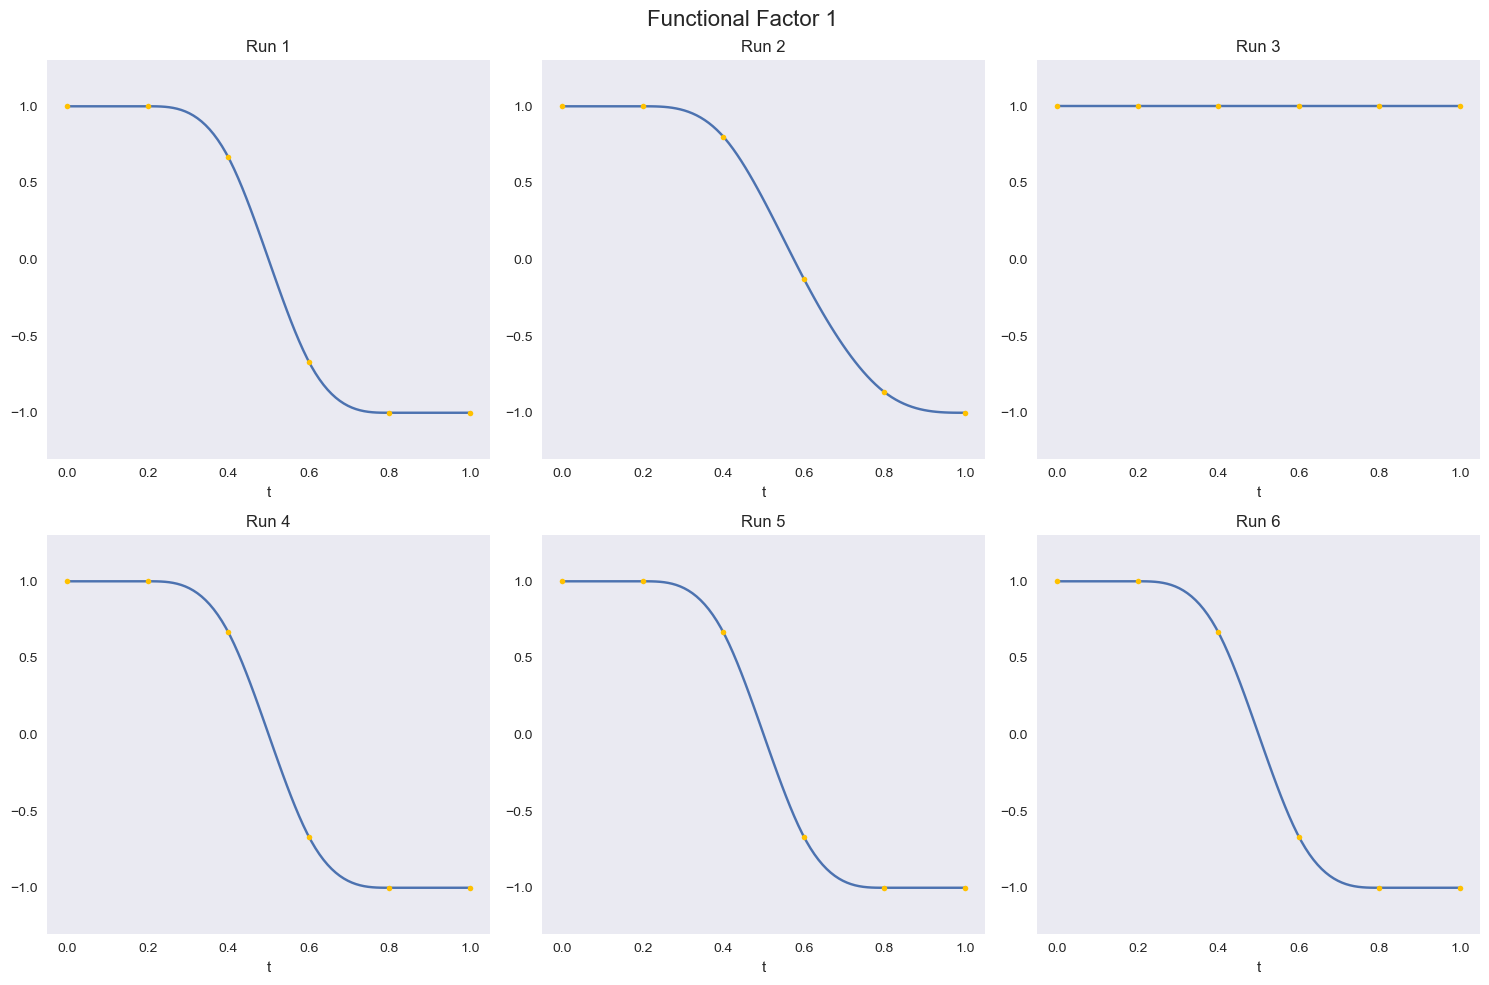

5.331269005454683


In [112]:
plot_design(best_design_penalty_large, [x_base], 6,
            sub_x=2, sub_y=3, colour="#FFC100") # FFC100
print(best_objective_value_penalty_large)

---

### Penalty Large + Different Sigma

In [124]:
model_penalty_sigma = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=1e-3, const=True, lambda_s=10, lambda_t=10, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())

In [133]:
model_penalty_sigma.Sigma

array([[1.        , 0.        , 0.        ],
       [0.        , 0.99950012, 0.        ],
       [0.        , 0.        , 0.9990005 ]])

In [125]:
optimizer_penalty_sigma = CordexContinuous(model=model_penalty_sigma, runs=6)

In [126]:
best_design_penalty_sigma, best_objective_value_penalty_sigma = optimizer_penalty_sigma.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


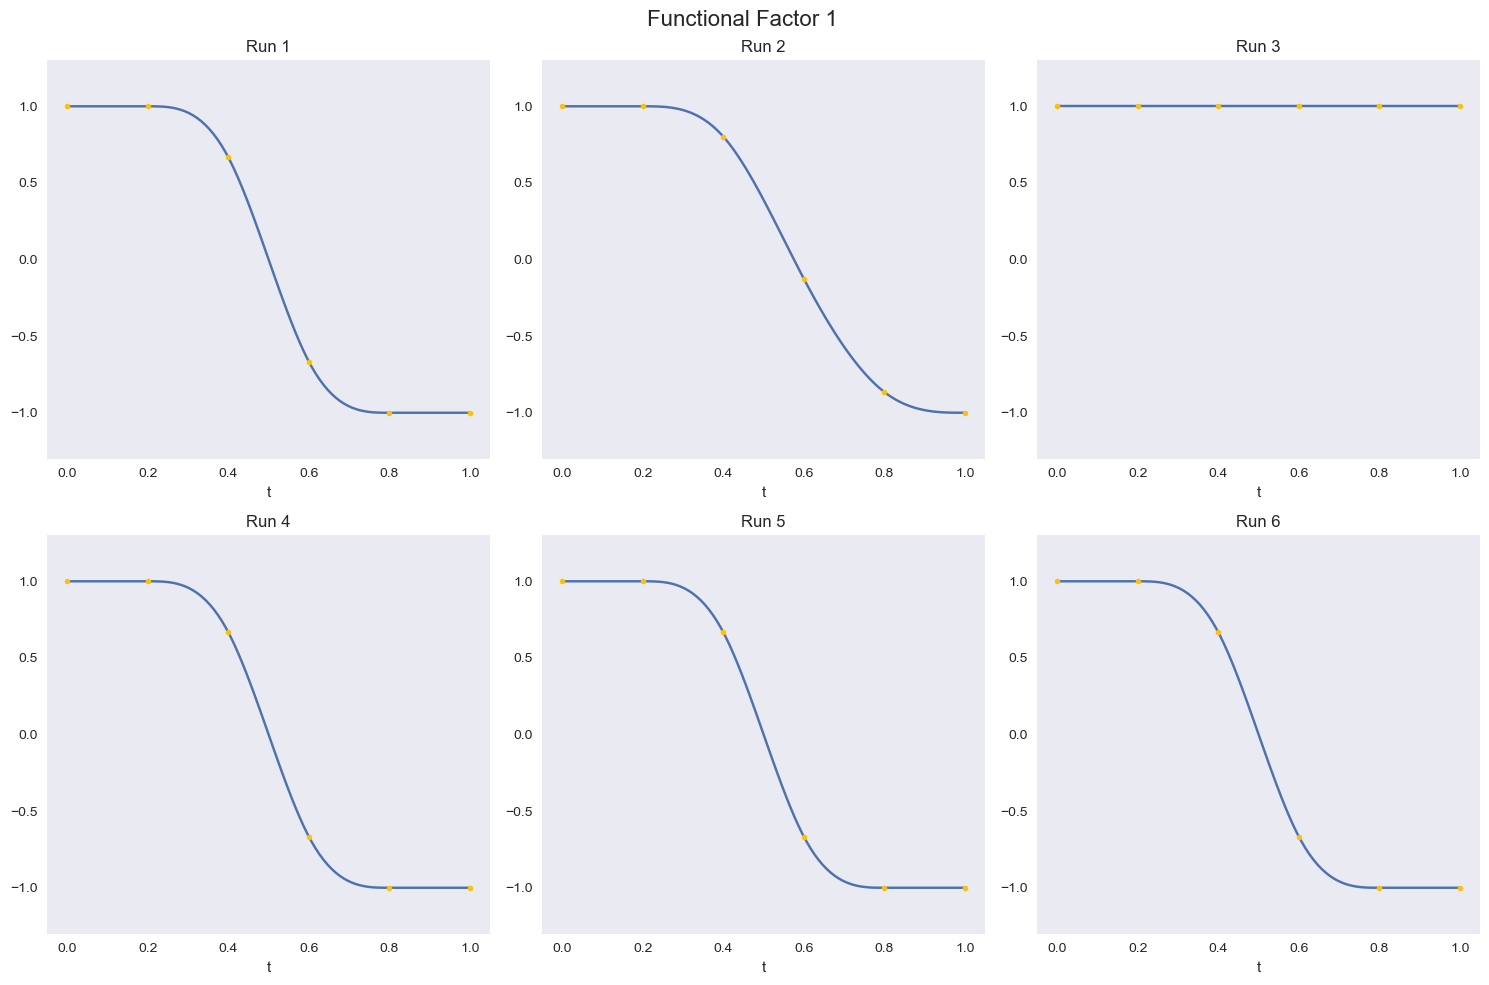

5.331269493394475


In [127]:
plot_design(best_design_penalty_sigma, [x_base], 6,
            sub_x=2, sub_y=3, colour="#FFC100") # FFC100
print(best_objective_value_penalty_sigma)

---

### Different PosDef Sigmas

In [98]:
Sigma1 = np.eye(3)
Sigma2 = np.array([
    [100,  80, 13],
    [80, 10, 0.5],
    [13, 0.5, 3]])

In [99]:
model_penalty_sigma_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=1e-3, const=True, lambda_s=0.1, lambda_t=0.1, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_penalty_sigma_1.set_Sigma(Sigma1)
optimizer_penalty_sigma_1 = CordexContinuous(model=model_penalty_sigma_1, runs=6)
best_design_penalty_sigma_1, best_objective_value_penalty_sigma_1 = optimizer_penalty_sigma_1.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


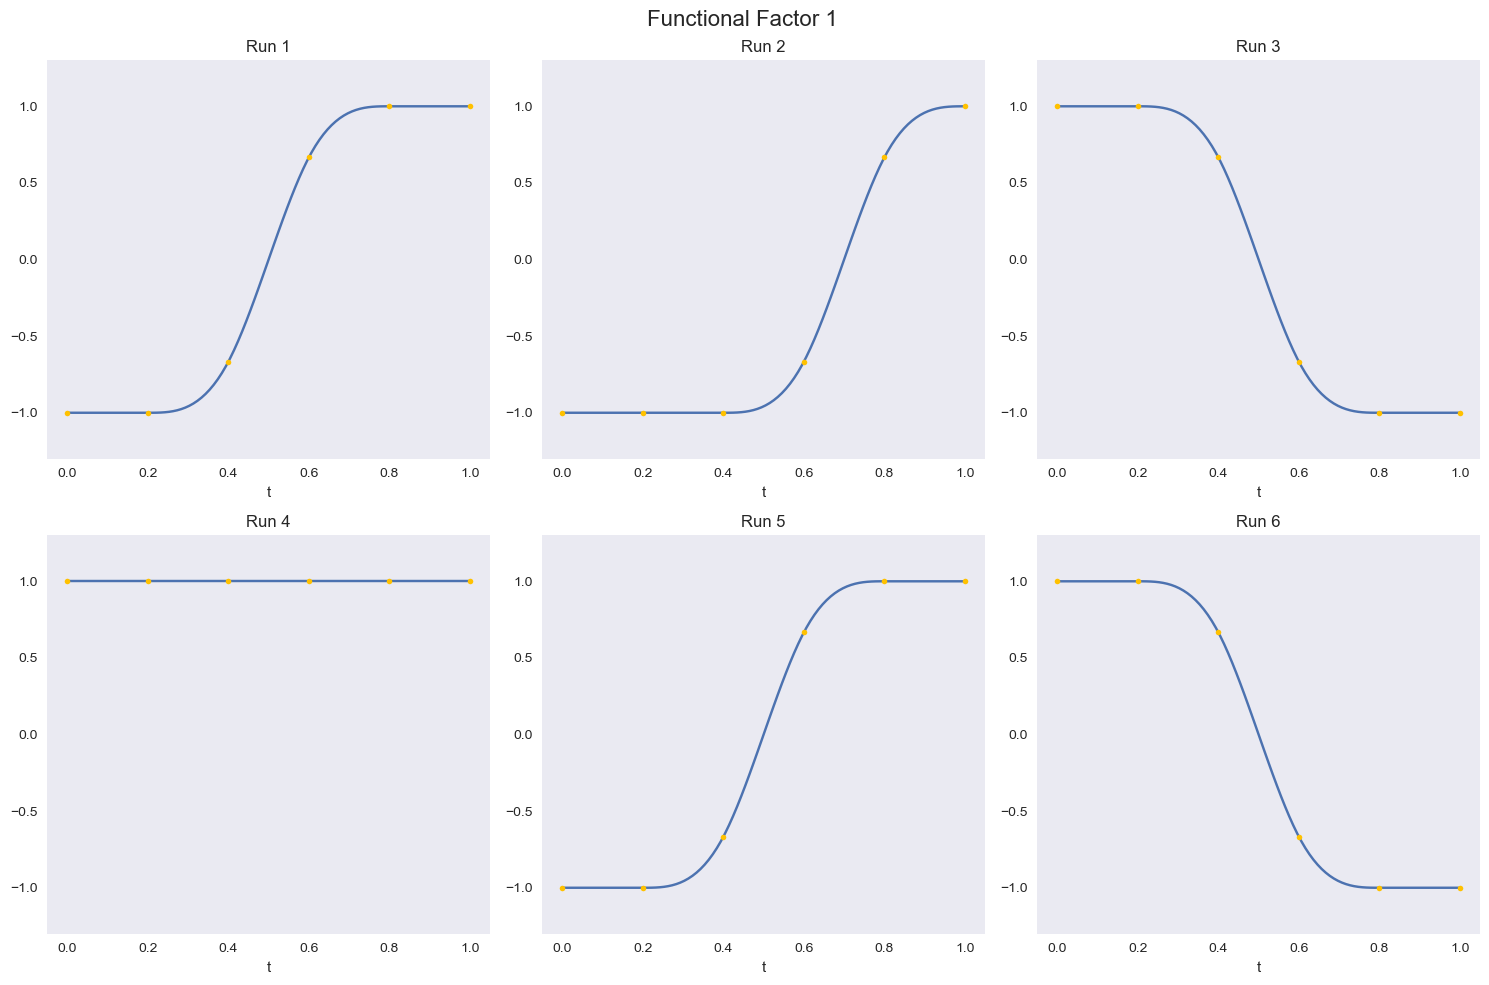

5.673709068932813


In [100]:
plot_design(best_design_penalty_sigma_1, [x_base], 6,
            sub_x=2, sub_y=3, colour="#FFC100") # FFC100
print(best_objective_value_penalty_sigma_1)

In [101]:
model_penalty_sigma_2 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=0, const=True, lambda_s=0.1, lambda_t=0.1, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
model_penalty_sigma_2.set_Sigma(Sigma2)
optimizer_penalty_sigma_2 = CordexContinuous(model=model_penalty_sigma_2, runs=6)
best_design_penalty_sigma_2, best_objective_value_penalty_sigma_2 = optimizer_penalty_sigma_2.optimize(epochs=1000, refinement_epochs=100)

100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


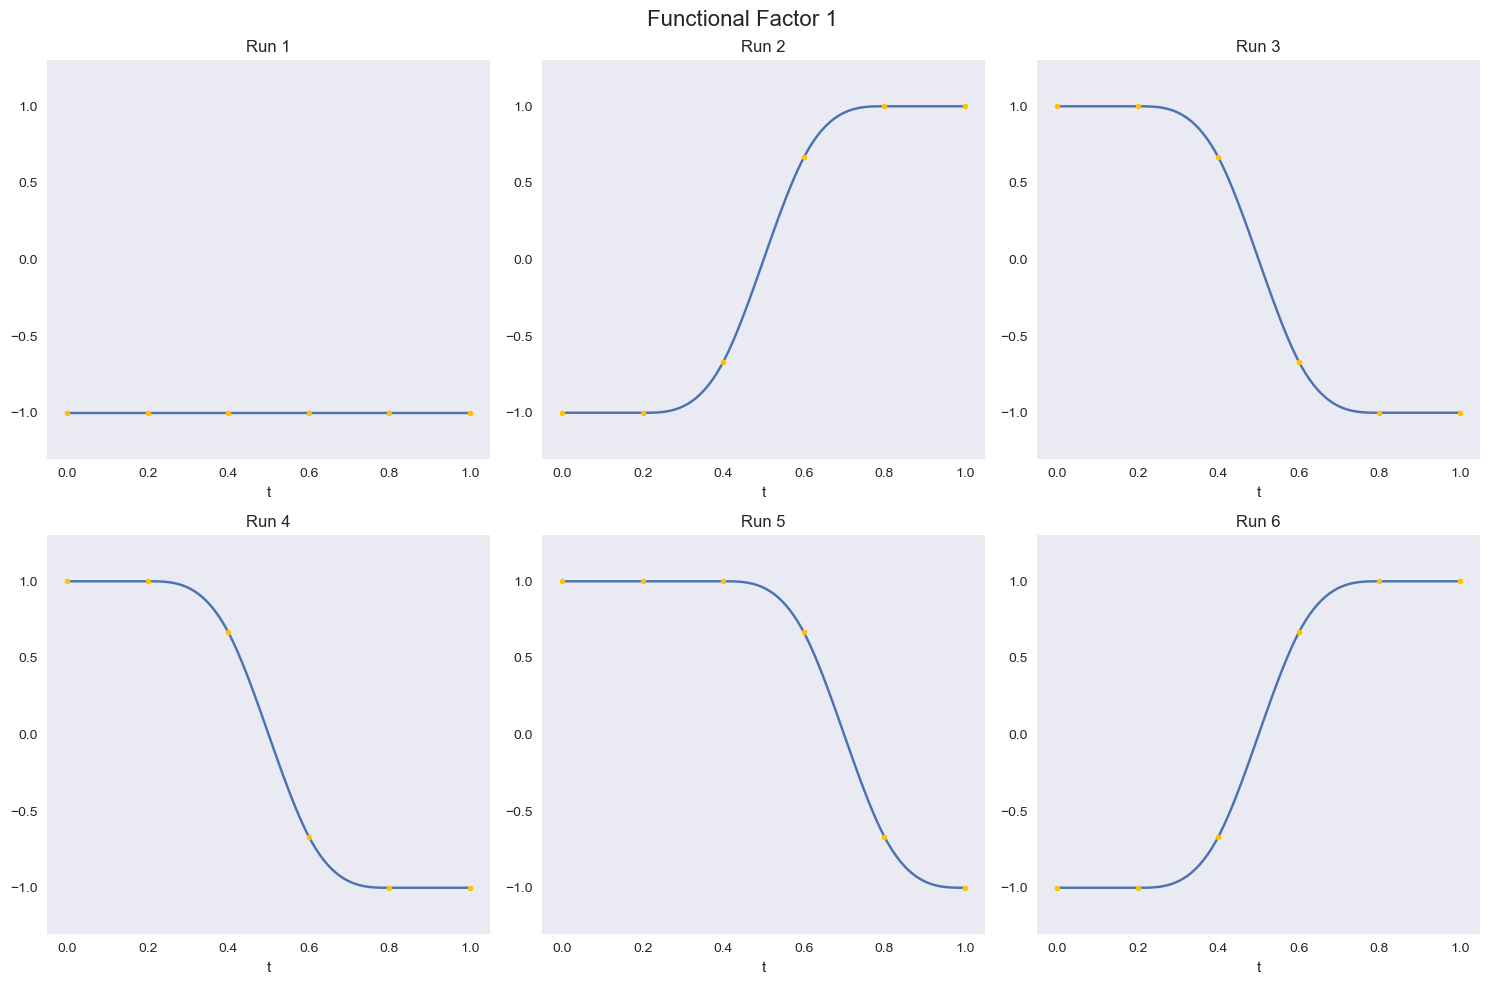

566.8947032589213


In [102]:
plot_design(best_design_penalty_sigma_2, [x_base], 6,
            sub_x=2, sub_y=3, colour="#FFC100") # FFC100
print(best_objective_value_penalty_sigma_2)

---

### Supersaturated Case

In [111]:
bs_base = PolynomialBasis(degree=5) # H
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=10, lambda_t=10, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())

In [112]:
optimizer = CordexContinuous(model=model, runs=4)
best_design, best_objective_value = optimizer.optimize(epochs=100, refinement_epochs=1)

100%|██████████| 1/1 [00:00<00:00, 16.69it/s]


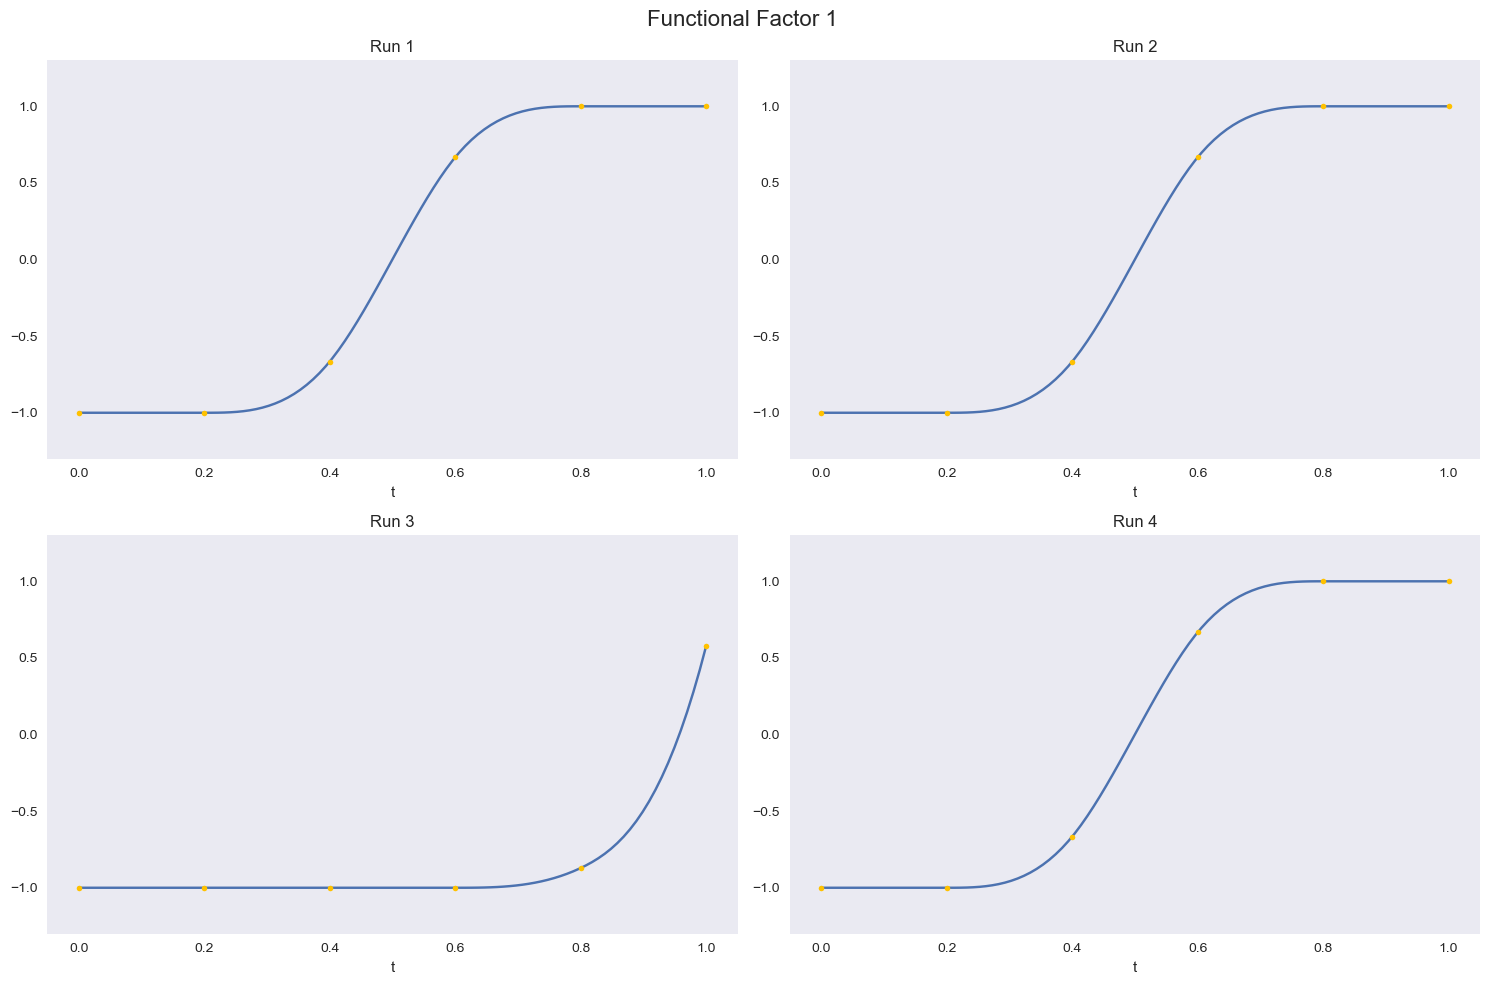

8.208278094806088


In [113]:
plot_design(best_design, [x_base], 4,
            sub_x=2, sub_y=2, colour="#FFC100") # FFC100
print(best_objective_value)

In [34]:
L = 5
A = 50 * np.random.rand(L,L)
semi_def = A.T @ A
Sigma_kalliopi = semi_def + 5 * np.eye(L)

x_base = BSplineBasis(degree=6, total_knots_num=8) # C
bs_base = BSplineBasis(degree=4, total_knots_num=6) # H
bt_base = FourierBasis(num_basis_functions=L) # theta
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = np.round(JMatrix(jch_pairs).compute(),3)
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = np.round(JMatrix(j_thetatheta).compute(),3)
R = np.round(compute_DER_MAT(jhh_pairs, const=True),3)
S = compute_DER_MAT(j_thetatheta, const=False)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the po

In [36]:
bt_base = FourierBasis(num_basis_functions=10) # theta
j_thetatheta = [(bt_base, bt_base)]
S = compute_DER_MAT(j_thetatheta, const=False)

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the po

In [38]:
lambda_t = 0.25/np.max(np.abs(np.kron(S, J_HH)))
lambda_t * S

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  4.00000041e-04, -2.41371849e-10,
         1.52027305e-09,  1.08394120e-09,  2.84245387e-09,
        -2.22406920e-09,  2.75312059e-09, -2.49657454e-09,
        -9.47078618e-09],
       [ 0.00000000e+00, -2.41371849e-10,  3.99999442e-04,
         6.56213614e-10, -1.14521948e-09,  1.18875117e-09,
         2.84407345e-09, -4.25575612e-09, -4.80496948e-09,
        -2.03821812e-09],
       [ 0.00000000e+00,  1.52027305e-09,  6.56213614e-10,
         6.40000110e-03, -4.45903241e-09, -2.97378322e-10,
         7.25613256e-09, -8.94876630e-09, -2.01701192e-08,
         5.13419120e-09],
       [ 0.00000000e+00,  1.08394120e-09, -1.14521948e-09,
        -4.45903241e-09,  6.39999883e-03,  3.44492983e-09,
        -4.83222348e-09, -1.80523128e-08,  6.99311011e-09,
        -1.

In [39]:
1//2

0

In [229]:
R

array([[ 1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  3.599998e+03, -4.875001e+03,  9.583340e+02,
         2.916670e+02,  2.500000e+01,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00, -4.875001e+03,  6.900000e+03, -1.695833e+03,
        -3.666670e+02,  3.437500e+01,  3.125000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  9.583340e+02, -1.695833e+03,  8.750000e+02,
        -8.055500e+01, -8.645800e+01,  2.766200e+01,  1.852000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  2.916670e+02, -3.666670e+02, -8.055500e+01,
         2.444440e+02, -7.187500e+01, -4.780100e+01,  2.766200e+01,
         3.125000e+00,  0.000000e+00],
       [ 0.000000e+00,  2.500000e+01,  3.437500e+01, -8.645800e+01,
        -7.187500e+01,  1.979170e+02, -7.187500e+01, -8.6

In [230]:
S

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 0.0000000e+00,  1.5585460e+03, -1.0000000e-03,  6.0000000e-03,
         4.0000000e-03],
       [ 0.0000000e+00, -1.0000000e-03,  1.5585430e+03,  3.0000000e-03,
        -4.0000000e-03],
       [ 0.0000000e+00,  6.0000000e-03,  3.0000000e-03,  2.4936732e+04,
        -1.7000000e-02],
       [ 0.0000000e+00,  4.0000000e-03, -4.0000000e-03, -1.7000000e-02,
         2.4936724e+04]])

In [231]:
# Suppose R is an n x m matrix
n, m = R.shape

# Create a new (n+1) x (m+1) matrix of zeros
R_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
R_aug[0, 0] = 1

# Place the original R into the bottom-right block
R_aug[1:, 1:] = R

In [232]:
# Suppose R is an n x m matrix
n, m = J_HH.shape

# Create a new (n+1) x (m+1) matrix of zeros
J_HH_aug = np.zeros((n+1, m+1))

# Set the top-left element to 1
J_HH_aug[0, 0] = 1

# Place the original R into the bottom-right block
J_HH_aug[1:, 1:] = J_HH

In [233]:
model_kalliopi = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s,
                                         lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model_kalliopi, runs=12)
best_design_kalliopi, best_objective_value_kallipi = optimizer.optimize(epochs=1, refinement_epochs=1)

100%|██████████| 1/1 [00:11<00:00, 11.71s/it]


In [234]:
Z = best_design_kalliopi
F_lambda_X = np.kron(np.eye(bt_base.num_basis()), Z.T @ Z)
F_lambda_X

array([[ 8.62881175,  8.96975972,  9.00444965, ...,  0.        ,
         0.        , -0.        ],
       [ 8.96975972,  9.93743833,  9.81561649, ...,  0.        ,
         0.        , -0.        ],
       [ 9.00444965,  9.81561649, 10.40099136, ...,  0.        ,
         0.        , -0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 12.        ,
        10.15423973,  7.11905645],
       [ 0.        ,  0.        ,  0.        , ..., 10.15423973,
         9.84754082,  7.38691141],
       [-0.        , -0.        , -0.        , ...,  7.11905645,
         7.38691141,  8.01458084]])

In [236]:
F_lambda_S = np.round(lambda_s * np.kron(np.eye(bt_base.num_basis()), R_aug),3)
F_lambda_S

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.13 , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.032, -0.061,  0.035],
       [ 0.   ,  0.   ,  0.   , ..., -0.061,  0.25 , -0.177],
       [ 0.   ,  0.   ,  0.   , ...,  0.035, -0.177,  0.13 ]])

In [237]:
F_lambda_T = np.round(np.kron(S, J_HH_aug),3)
F_lambda_T

array([[   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       ...,
       [   0.   ,    0.   ,    0.   , ..., 1159.426,  613.578,   86.531],
       [   0.   ,    0.   ,    0.   , ...,  613.578,  827.266,  347.333],
       [   0.   ,    0.   ,    0.   , ...,   86.531,  347.333,  554.149]])

In [206]:
F_lambda = F_lambda_X + F_lambda_S + F_lambda_T
F_lambda

ValueError: operands could not be broadcast together with shapes (40,40) (55,55) 

In [ ]:
F_lambda_inv = np.round(np.linalg.inv(F_lambda),3)
F_lambda_inv

In [217]:
Sigma_cross_ZTZ = np.kron(Sigma_kalliopi, Z.T @ Z)
Sigma_cross_ZTZ

array([[25934.5716567 , 21675.43469131, 20732.85520333, ...,
         1235.31623467, -2526.65455039,   506.17432253],
       [21675.43469131, 43069.73055467, 41975.3763899 , ...,
         5529.36889979, -1088.24151394,  2711.62126435],
       [20732.85520333, 41975.3763899 , 42698.40593375, ...,
         3910.81855561, -2277.56469088,  2039.27425887],
       ...,
       [ 1235.31623467,  5529.36889979,  3910.81855561, ...,
        33081.55282707, 22948.42052306, 12199.97293156],
       [-2526.65455039, -1088.24151394, -2277.56469088, ...,
        22948.42052306, 22584.24687378, 10260.35568918],
       [  506.17432253,  2711.62126435,  2039.27425887, ...,
        12199.97293156, 10260.35568918, 15534.94560425]])

---

### Last Example

In [10]:
L = 5
A = 50 * np.random.rand(L,L)
semi_def = A.T @ A
Sigma1 = semi_def + 5 * np.eye(L)

A = 50 * np.random.normal(12, 2, L*L).reshape(L,L)
semi_def = A.T @ A
Sigma2 = semi_def + 5 * np.eye(L)

In [45]:
bt_base = FourierBasis(num_basis_functions=3) # theta
j_thetatheta = [(bt_base, bt_base)]
S = compute_DER_MAT(j_thetatheta, const=False)
S

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.55854567e+03, -9.40472530e-04],
       [ 0.00000000e+00, -9.40472530e-04,  1.55854334e+03]])

In [68]:
x_base = BSplineBasis(degree=3, total_knots_num=8) # C
bs_base = BSplineBasis(degree=2, total_knots_num=6) # H
bt_base = FourierBasis(num_basis_functions=5) # theta
bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

lambda_s = 0.25
lambda_t = 0.25
lambda_s = lambda_s/np.max(np.abs(R))
## a/b = e^(log(a) - log(b))
lambda_t = lambda_t/np.max(np.abs(np.kron(S, J_HH)))

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-6, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_69320/2707710733.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R[i, j], _ = quad(integrand, 0, 1)
/var/folder

In [69]:
S

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.55854567e+03, -9.40472530e-04,
         5.92353684e-03,  4.22342924e-03],
       [ 0.00000000e+00, -9.40472530e-04,  1.55854334e+03,
         2.55684695e-03, -4.46219169e-03],
       [ 0.00000000e+00,  5.92353684e-03,  2.55684695e-03,
         2.49367325e+04, -1.73740124e-02],
       [ 0.00000000e+00,  4.22342924e-03, -4.46219169e-03,
        -1.73740124e-02,  2.49367236e+04]])

In [74]:
model_1 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=np.round(S,3), J_HH=J_HH, Kb_t=bt_base.num_basis())
model_1.set_Sigma(Sigma1)
optimizer_1 = CordexContinuous(model=model_1, runs=8)
best_design_1, best_objective_value_1 = optimizer_1.optimize(epochs=1000, refinement_epochs=1000)

100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]


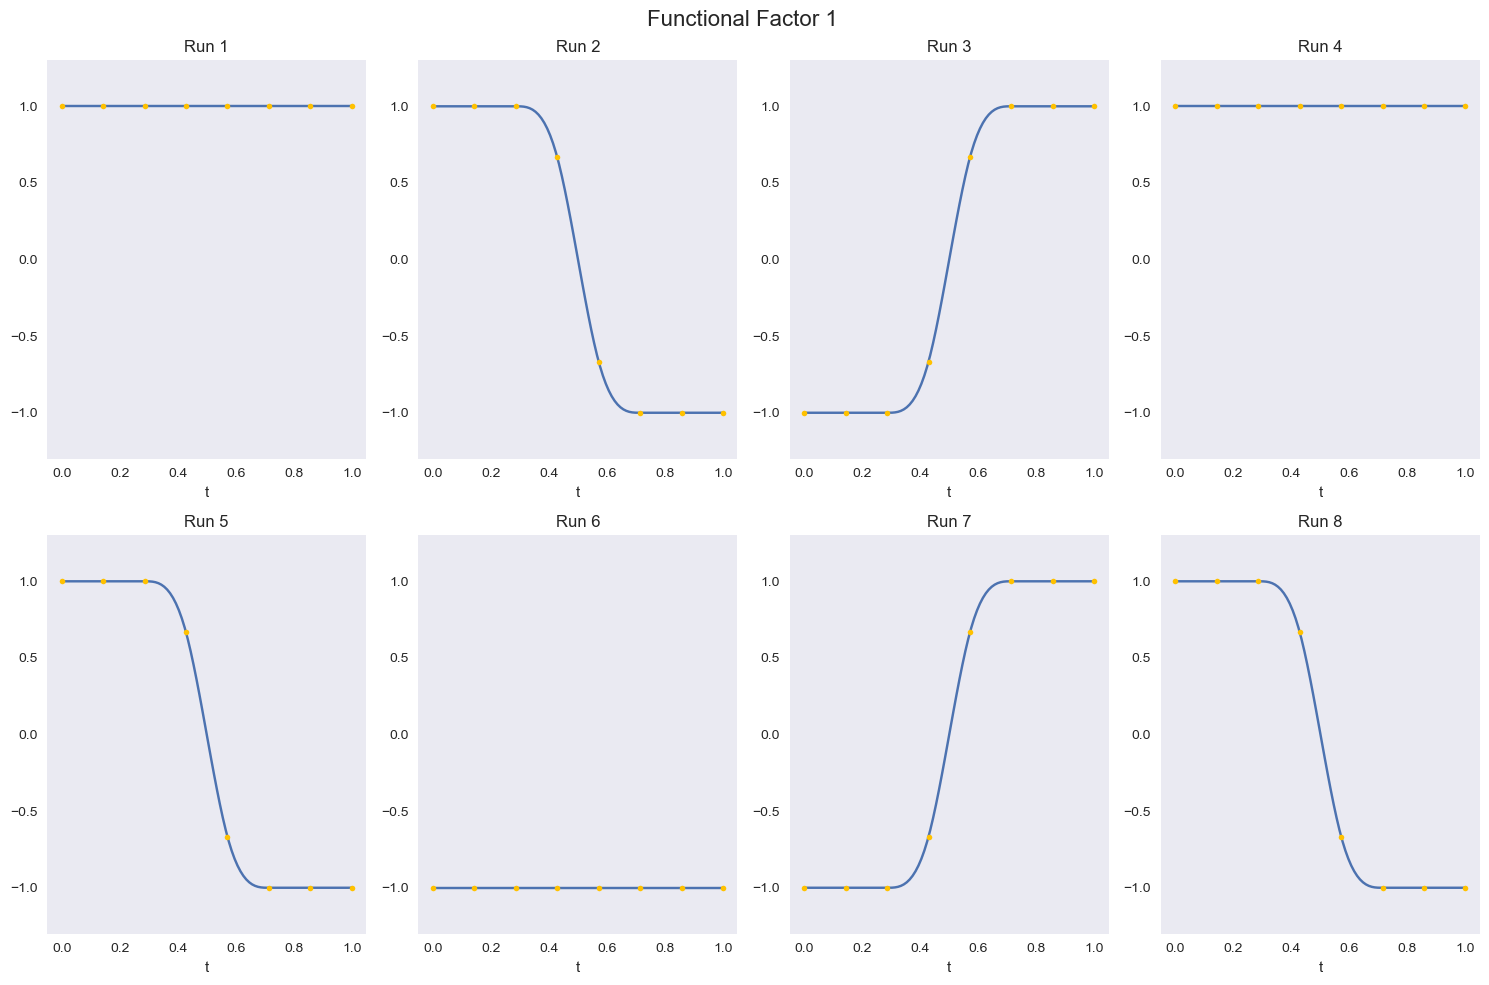

74131.78538803007


In [75]:
plot_design(best_design_1, [x_base], 8,
            sub_x=2, sub_y=4, colour="#FFC100") # FFC100
print(best_objective_value_1)

In [72]:
model_2 = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=np.round(S,3), J_HH=J_HH, Kb_t=bt_base.num_basis())
model_2.set_Sigma(Sigma2)
optimizer_2 = CordexContinuous(model=model_2, runs=8)
best_design_2, best_objective_value_2 = optimizer_2.optimize(epochs=1000, refinement_epochs=1000)

100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


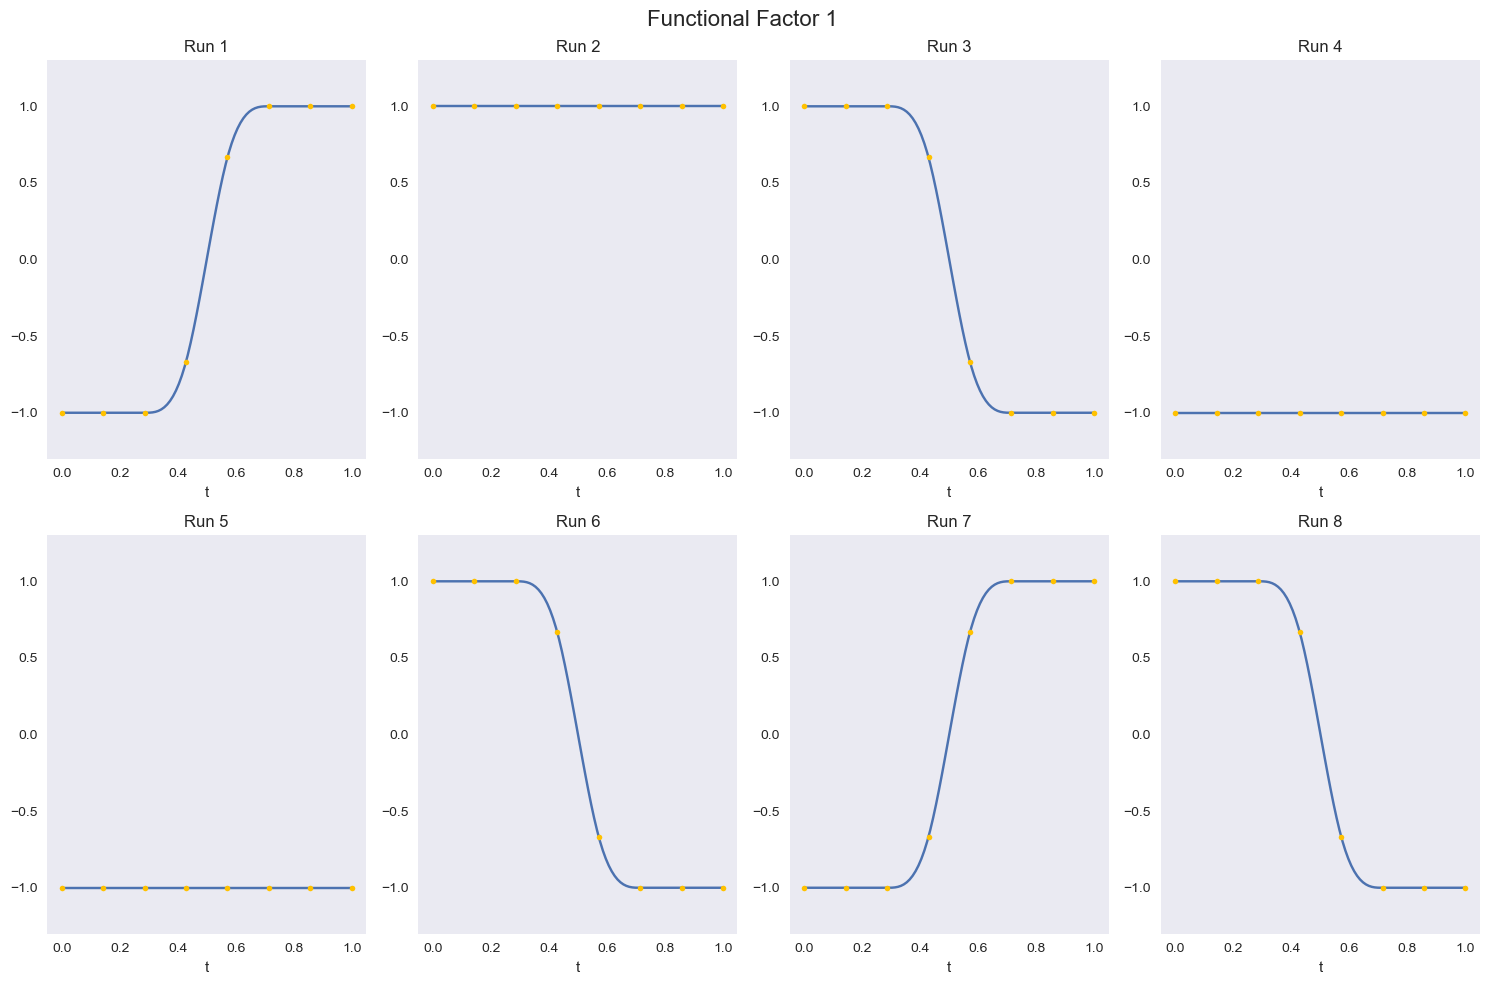

46027467.5607609


In [73]:
plot_design(best_design_2, [x_base], 8,
            sub_x=2, sub_y=4, colour="#FFC100") # FFC100
print(best_objective_value_2)